In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.tseries.offsets import DateOffset

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import keras.backend as K

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

### Load data and preprocessing

In [2]:
#reading and saving each stock data into a dictionary
file_path = "2020Q1Q2Q3Q4-2021Q1.xlsx"

sheets = pd.ExcelFile(file_path)

df_dic = {}

for sheet_name in sheets.sheet_names:
  df = pd.read_excel(file_path,sheet_name = sheet_name, index_col="Date", parse_dates=["Date"])
  df_dic[sheet_name] = df[:-1]

Data are loaded as a dict of dataframes (one for each sheet). The last row is omitted because doesn't represent data but just a summary.

In [3]:
df_dic

{'Russia - Sberbank Rossii PAO (S':                       Price    Open    High     Low    Vol.  Change %
 Date                                                                 
 2021-03-31 00:00:00  291.02     294  294.42  290.26  47.00M   -0.0076
 2021-03-30 00:00:00  293.25  294.86  295.72   291.5  38.81M   -0.0002
 2021-03-29 00:00:00   293.3  289.72  294.09  289.26  43.68M    0.0071
 2021-03-26 00:00:00  291.22  288.63  292.75  288.32  56.07M    0.0159
 2021-03-25 00:00:00  286.66   286.5  287.03  283.85  35.22M    0.0030
 ...                     ...     ...     ...     ...     ...       ...
 2020-01-10 00:00:00  258.19  257.86  259.25  256.88  18.85M    0.0008
 2020-01-09 00:00:00  257.99   259.4  261.76  257.01  38.33M   -0.0045
 2020-01-08 00:00:00  259.15  253.57  259.15  253.03  40.82M    0.0207
 2020-01-06 00:00:00   253.9  254.75  254.84   251.4  22.35M   -0.0043
 2020-01-03 00:00:00     255  255.99  258.19   253.7  35.85M    0.0010
 
 [311 rows x 6 columns],
 'Turkey - Koc 

In [4]:
company_name = list(df_dic.keys())

for i in range(len(company_name)):
      print(f"{i} {company_name[i]}")

0 Russia - Sberbank Rossii PAO (S
1 Turkey - Koc Holding AS (KCHOL)
2 Egypt - Medinet Nasr Housing (M
3 Brazil - Minerva SABrazil (BEEF
4 Argentina - Pampa Energia SA (P
5 Colombia - Cementos Argos SA (C
6 South Africa - Impala Platinum 
7 South Korea - Dongkuk Steel Mil


In [5]:

for key in df_dic:
    df = df_dic[key]
    #converting to float datatype and removing strings
    df['Vol.'] = df['Vol.'].str.replace('M', 'e6').str.replace('K', 'e3').str.replace('-', '0').astype(float)
    df = df.astype(float)

    #fixing datatime index
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    df_dic[key] = df
    print(key)
    df.info()
    print(df.tail())

Russia - Sberbank Rossii PAO (S
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311 entries, 2020-01-03 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     311 non-null    float64
 1   Open      311 non-null    float64
 2   High      311 non-null    float64
 3   Low       311 non-null    float64
 4   Vol.      311 non-null    float64
 5   Change %  311 non-null    float64
dtypes: float64(6)
memory usage: 17.0 KB
             Price    Open    High     Low        Vol.  Change %
Date                                                            
2021-03-25  286.66  286.50  287.03  283.85  35220000.0    0.0030
2021-03-26  291.22  288.63  292.75  288.32  56070000.0    0.0159
2021-03-29  293.30  289.72  294.09  289.26  43680000.0    0.0071
2021-03-30  293.25  294.86  295.72  291.50  38810000.0   -0.0002
2021-03-31  291.02  294.00  294.42  290.26  47000000.0   -0.0076
Turkey - Koc Holding AS (KCHOL)
<clas

In [6]:
df_dic['Russia - Sberbank Rossii PAO (S'].head()

Price    Open    High     Low        Vol.  Change %
Date                                                            
2020-01-03  255.00  255.99  258.19  253.70  35850000.0    0.0010
2020-01-06  253.90  254.75  254.84  251.40  22350000.0   -0.0043
2020-01-08  259.15  253.57  259.15  253.03  40820000.0    0.0207
2020-01-09  257.99  259.40  261.76  257.01  38330000.0   -0.0045
2020-01-10  258.19  257.86  259.25  256.88  18850000.0    0.0008

### EDA

1. checking missing values

In [7]:
for key in df_dic:
    print(f'{key} \n {df_dic[key].isnull().sum()}')

Russia - Sberbank Rossii PAO (S 
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
Turkey - Koc Holding AS (KCHOL) 
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
Egypt - Medinet Nasr Housing (M 
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
Brazil - Minerva SABrazil (BEEF 
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
Argentina - Pampa Energia SA (P 
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
Colombia - Cementos Argos SA (C 
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
South Africa - Impala Platinum  
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
South Korea - Dongkuk Steel Mil 
 Price       0
Open        0
High        0
Low    

There are no missing values.

2) Visualize data to inspect outliers

In [8]:
#Ploting linechat to vizualize the stock price variation

def EDA_plot(df,name):
  plt.figure(figsize=(18,8))
  plt.fill_between(df.index, df['Low'], df['High'], alpha=0.3, label = " Low/High")
  plt.plot(df['Price'], linewidth=1, label = "Final Price")
  plt.title(f"Linechart - Price Plot: {name}")
  plt.legend()
  plt.show()


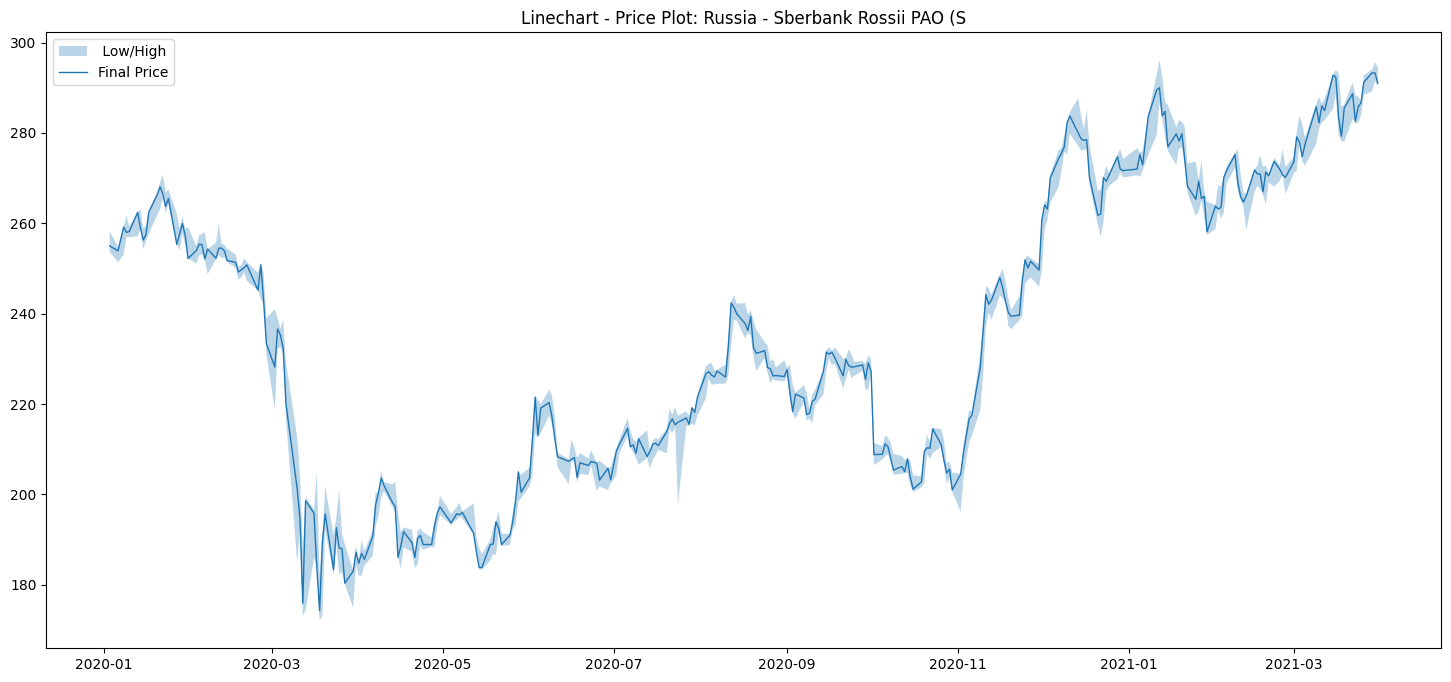

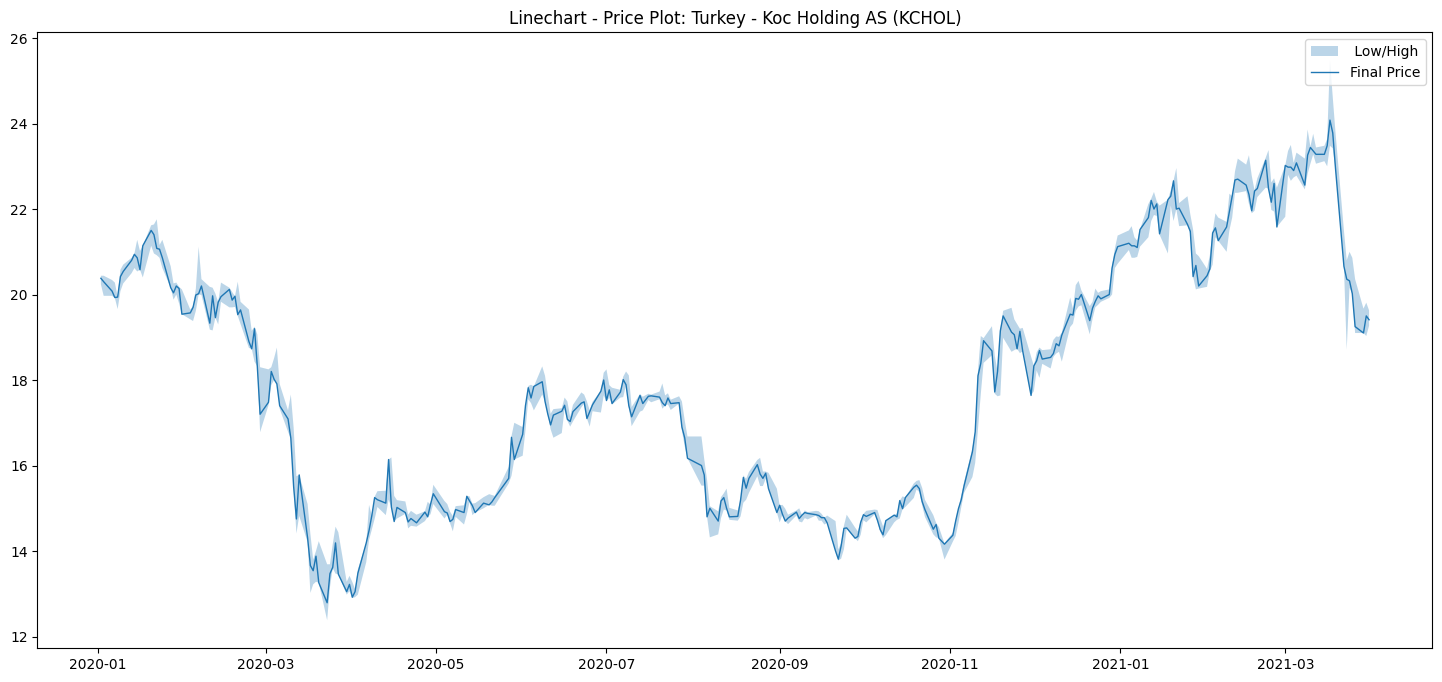

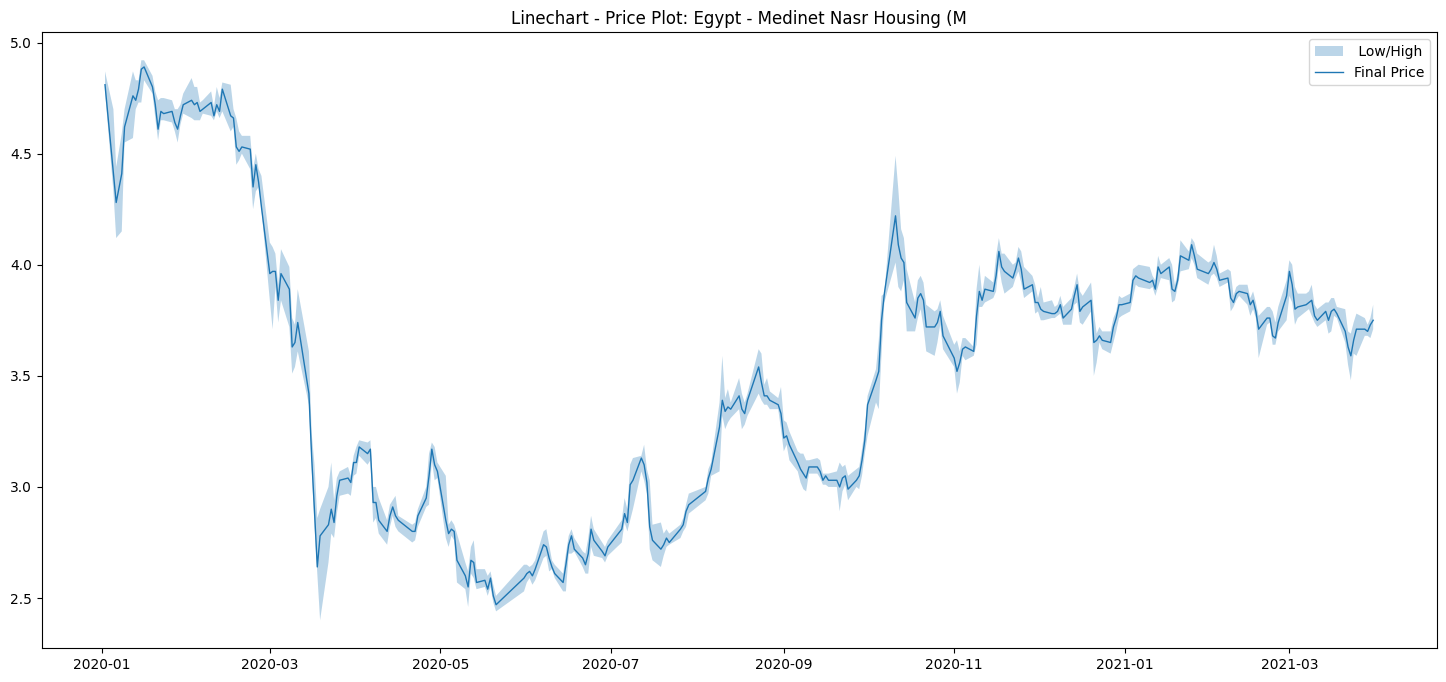

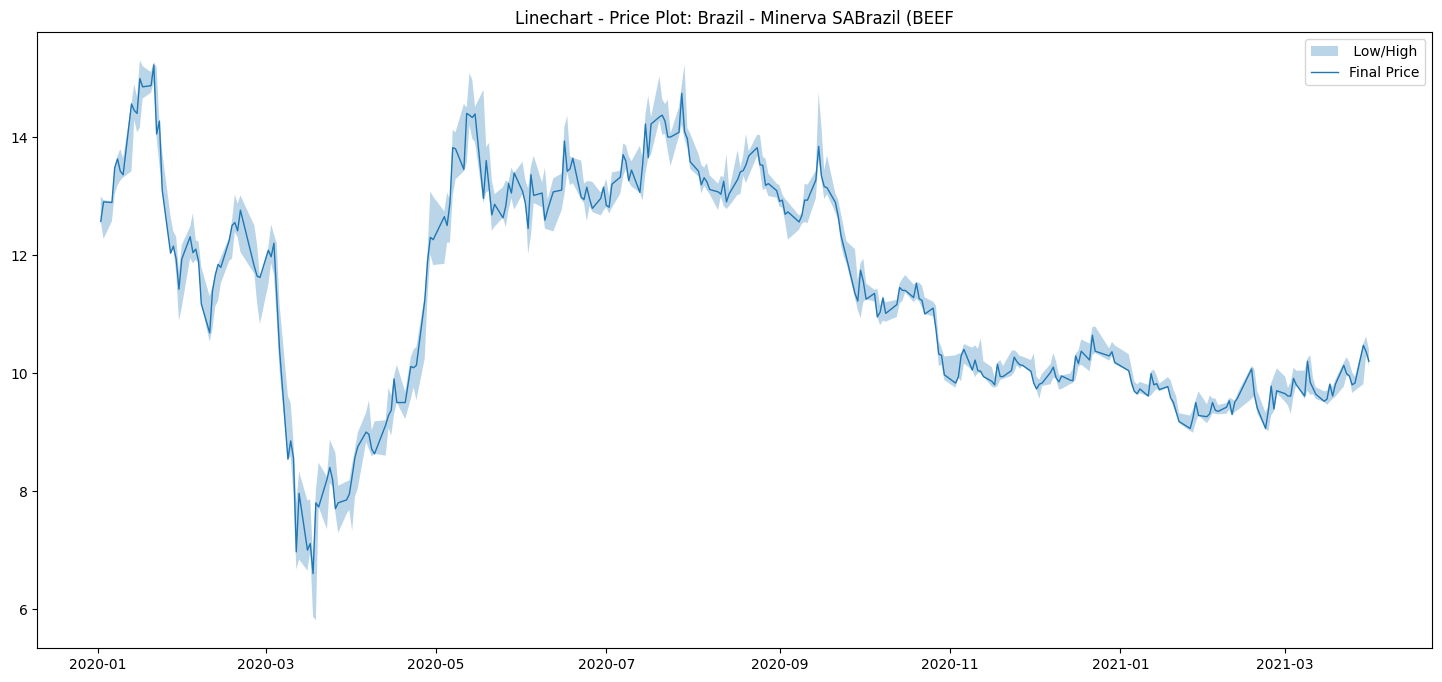

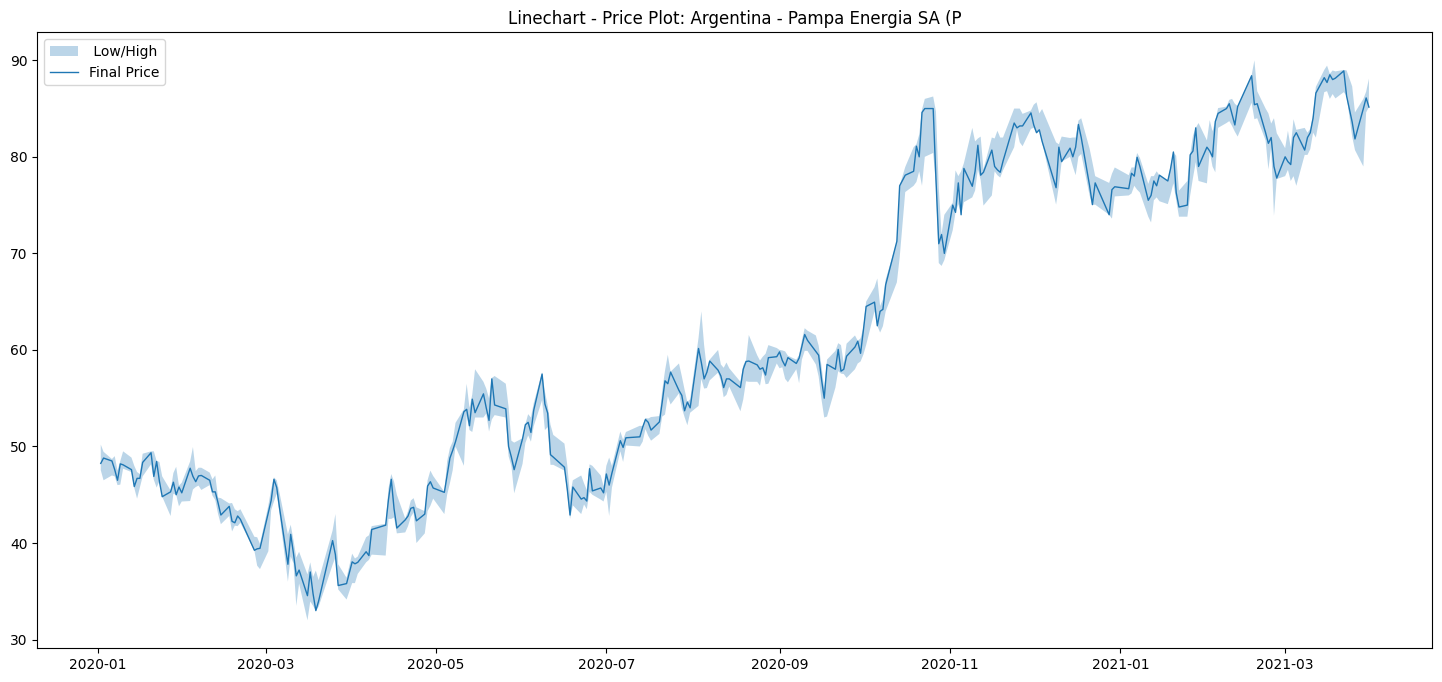

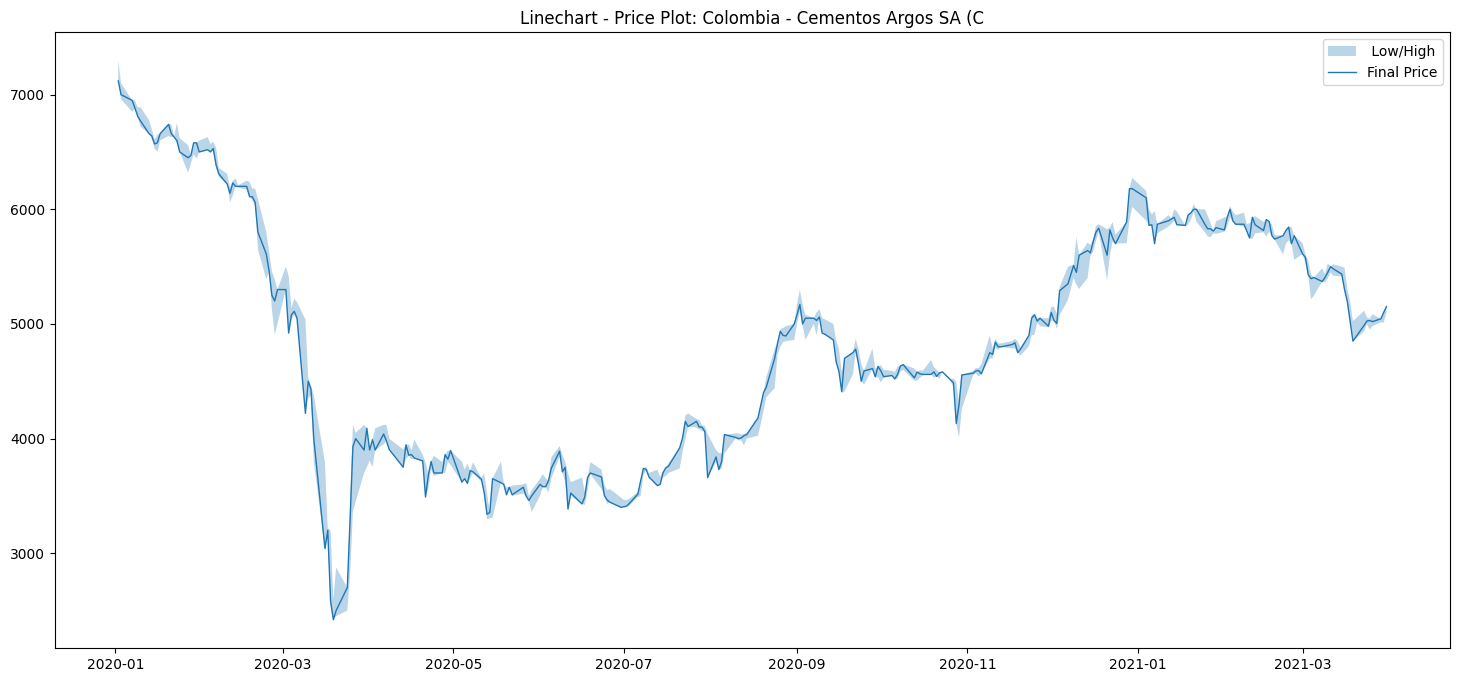

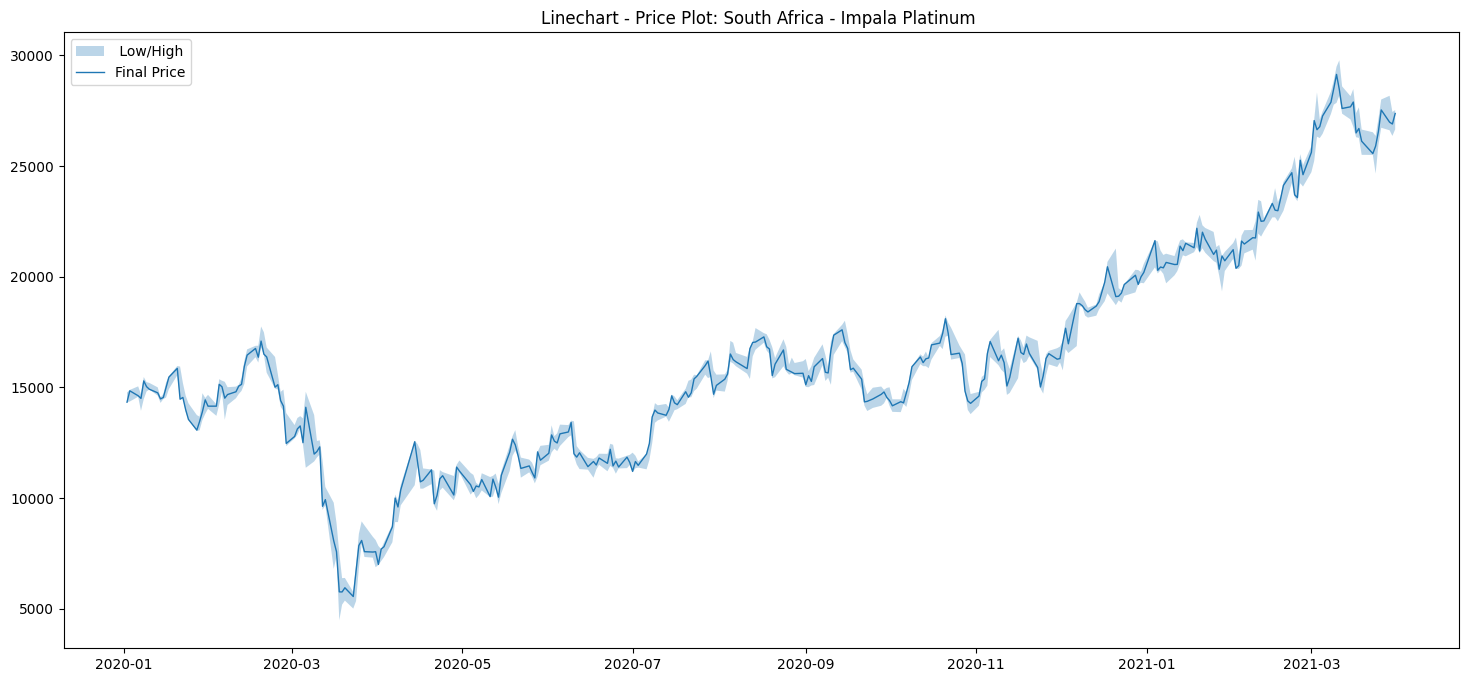

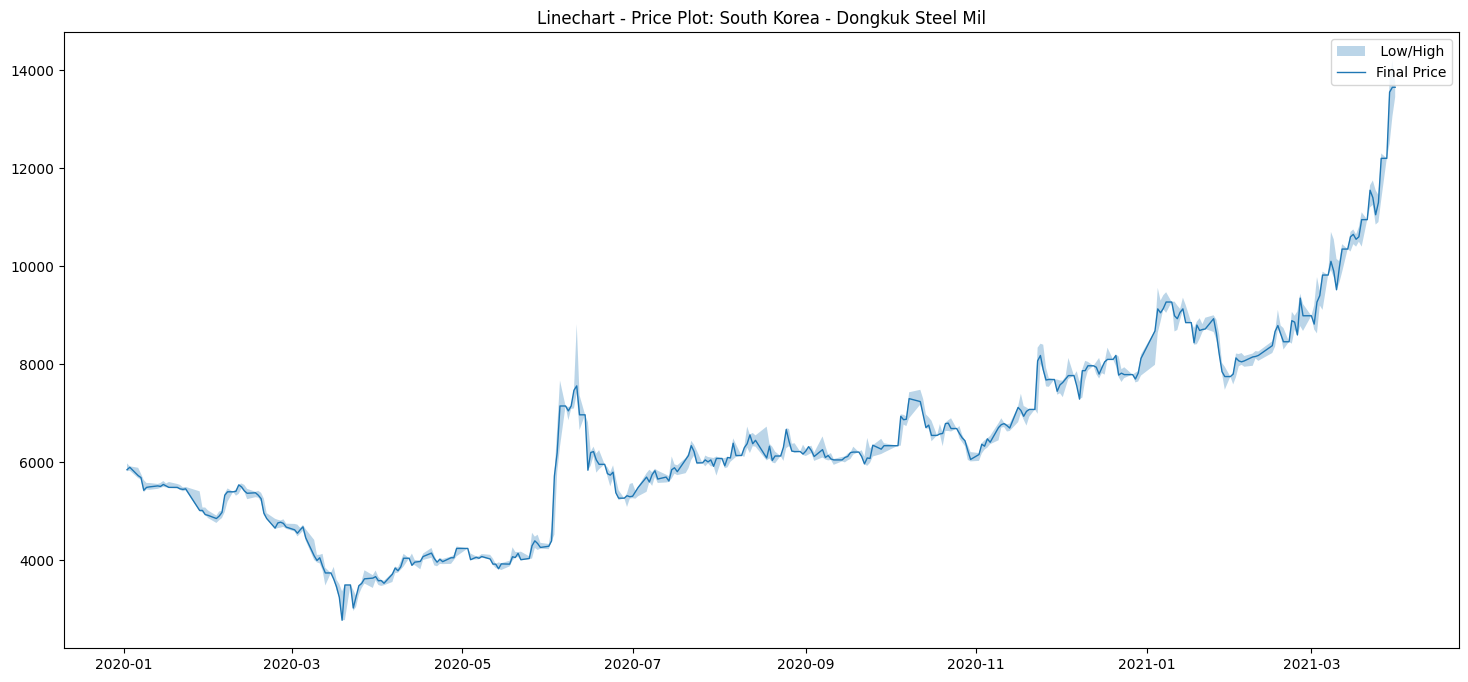

In [9]:
for key in df_dic:
    EDA_plot(df_dic[key], name = key)


Looking at the trend there are no specific outliers to evidence

### Forecasting with ARIMA

In [10]:
def ARIMA_prerun(df):

    #preprocessing the dataset for ARIMA model
    train_ARIMA = df.loc['2020', ['Price']].copy()
    test_ARIMA = df.loc['2021', ['Price']].copy()

    train_index = train_ARIMA.index
    forecast_index = test_ARIMA.index

    train_ARIMA.reset_index(drop=True,inplace=True)
    test_ARIMA.reset_index(drop=True,inplace=True)

    #Creating continous index range with day frequency
    train_ARIMA.index = pd.date_range(start='2020-01-03', periods=len(train_ARIMA), freq='D')
    test_ARIMA.index = pd.date_range(start=train_ARIMA.index[-1]+pd.Timedelta(days=1), periods=len(test_ARIMA), freq='D')

    #dickey fuller test
    dftest = adfuller(train_ARIMA['Price'])
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    labels = ['Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(dftest,labels):
      print(label+' : '+str(value) )
    if (pvalue < 0.05) and (adf < critical_value):
      print('The series is stationary')
    else:
      print('The series is NOT stationary')

    results_1 = seasonal_decompose(train_ARIMA['Price'], model = 'additive')
    fig = plt.figure()
    fig = results_1.plot()
    fig.set_size_inches(8, 6)
    fig.show()

    return train_ARIMA, test_ARIMA, train_index, forecast_index




def ARIMA_forecast(train_ARIMA, test_ARIMA, train_index, forecast_index,name):

    #auto arima model
    ARIMA_model = auto_arima(train_ARIMA['Price'],
                          start_p=0,
                          start_q=0,
                          test='adf',
                          max_p=3, max_q=3,
                          m=1,
                          d=None,
                          seasonal=False,
                          trace=False,
                          error_action='warn',
                          suppress_warnings=True,
                          stepwise=True)
    print("ARIMA Order:",ARIMA_model.order)

    # Forecast
    n_periods = len(test_ARIMA)
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(train_ARIMA.index[-1]+pd.Timedelta(days=1), periods =n_periods, freq='D')

    forecast_df = pd.DataFrame({'Fitted': fitted,'Lower': confint[:, 0],'Upper': confint[:, 1]}, index=index_of_fc)

    # Calculate MAPE for each forecast point
    forecast_df['MAPE'] = abs((test_ARIMA['Price'] - forecast_df['Fitted']) / test_ARIMA['Price']) * 100
    mape = forecast_df['MAPE'].mean()
    print(f"\n\nMean Absolute Percentage Error (MAPE): {mape:.2f}%")

    test_ARIMA.index = forecast_index
    train_ARIMA.index = train_index
    forecast_df.reset_index(drop = True,inplace = True)
    forecast_df.index = forecast_index

    # Plotting
    plt.figure(figsize=(15, 7))
    # plt.plot(train_ARIMA["Price"], color='Blue', label="Historic Price")
    plt.plot(test_ARIMA["Price"], color='Green', label="Actual Price")
    plt.plot(forecast_df['Fitted'], color='red', label="Forecast")
    plt.fill_between(forecast_df.index,
                    forecast_df['Lower'],
                    forecast_df['Upper'],
                    color='k', alpha=.15, label="Forecast - Low/High")

    plt.title(f"ARIMA - Forecast of Stock : {name}")
    plt.legend()
    plt.show()

    return ARIMA_model,forecast_df

Test Statistic : -1.4233235279675989
p-value : 0.5710448680935892
#Lags Used : 8
Number of Observations Used : 241
The series is NOT stationary
Russia - Sberbank Rossii PAO (S
ARIMA Order: (0, 1, 0)


Mean Absolute Percentage Error (MAPE): 2.91%


<Figure size 640x480 with 0 Axes>

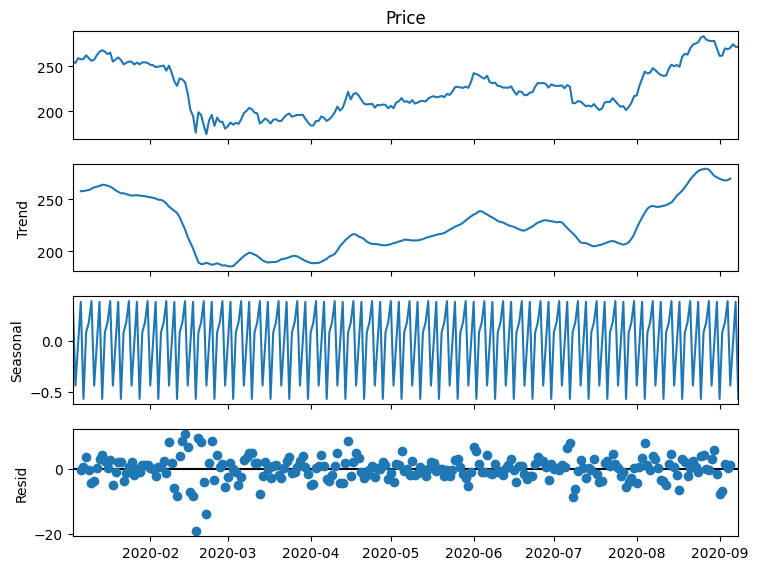

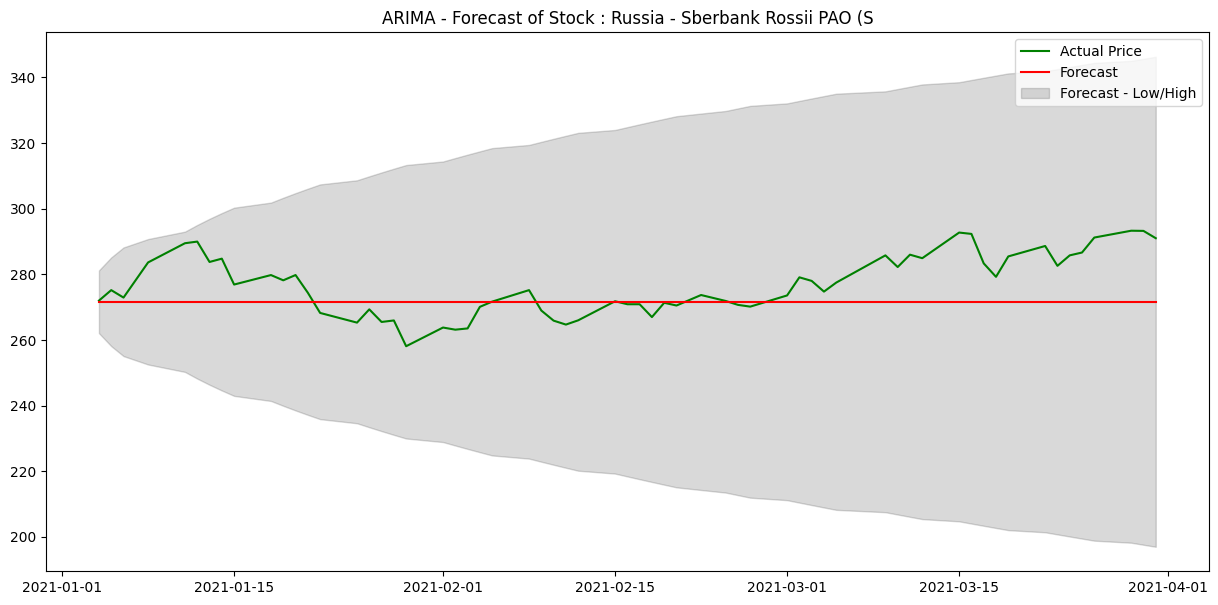

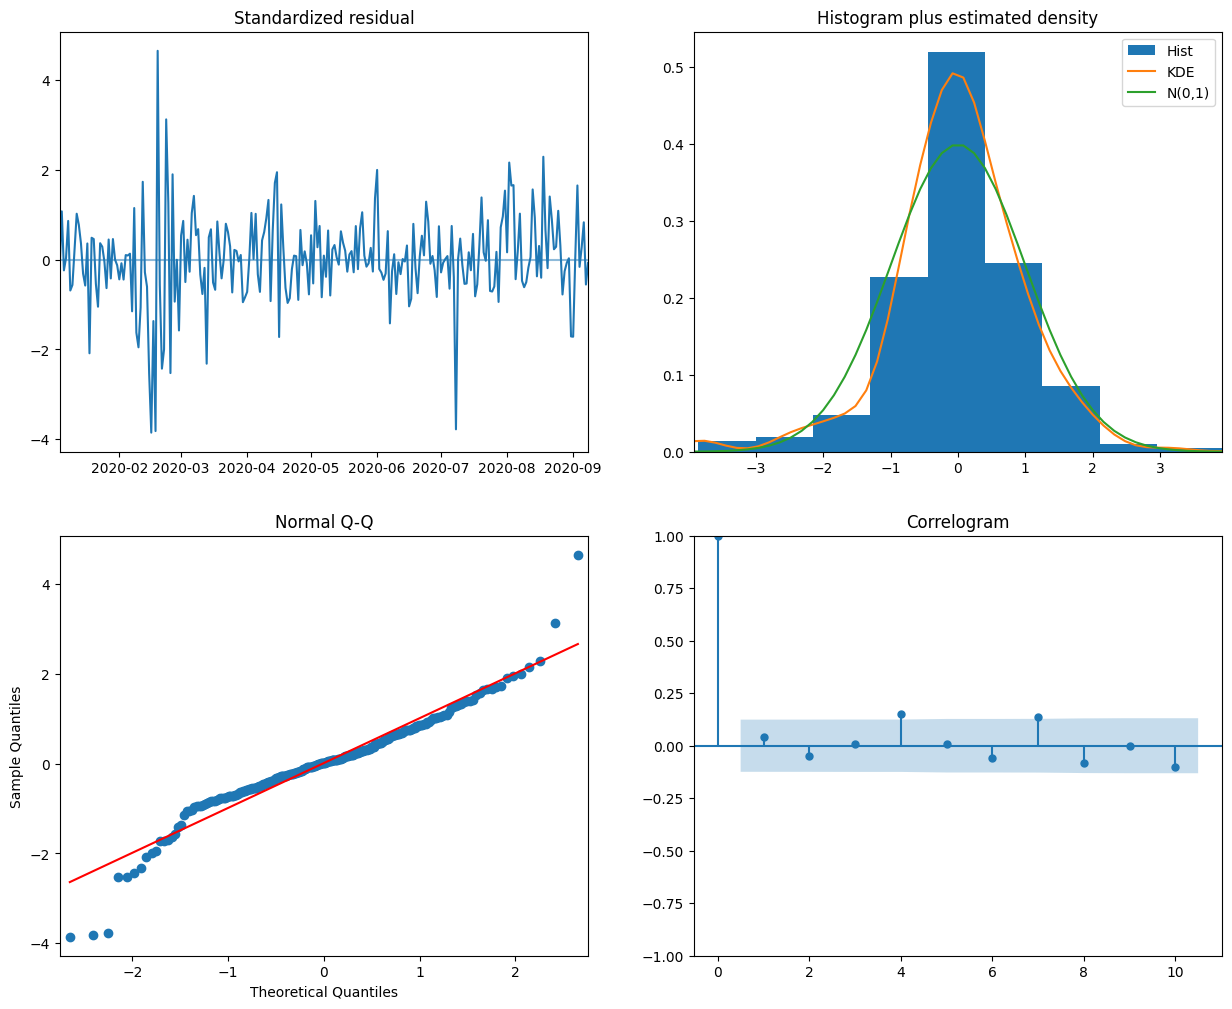

Test Statistic : -1.5241208674753024
p-value : 0.5215471446531409
#Lags Used : 4
Number of Observations Used : 247
The series is NOT stationary
Turkey - Koc Holding AS (KCHOL)
ARIMA Order: (0, 1, 0)


Mean Absolute Percentage Error (MAPE): 5.38%


<Figure size 640x480 with 0 Axes>

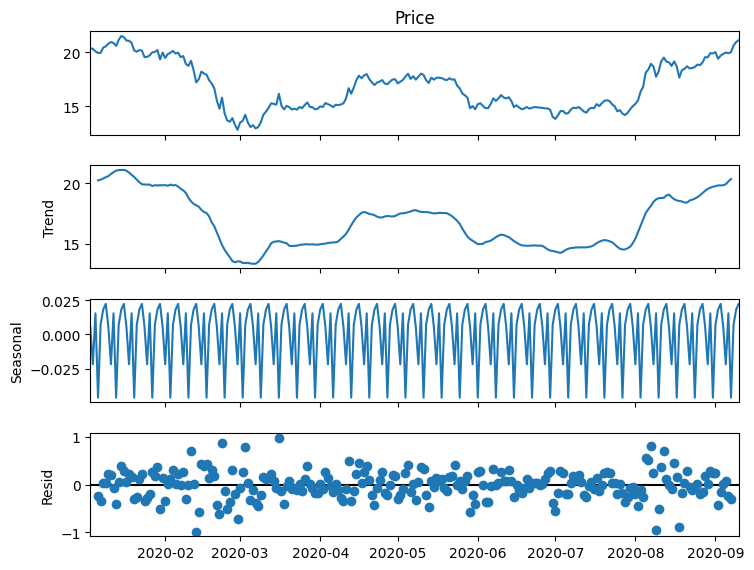

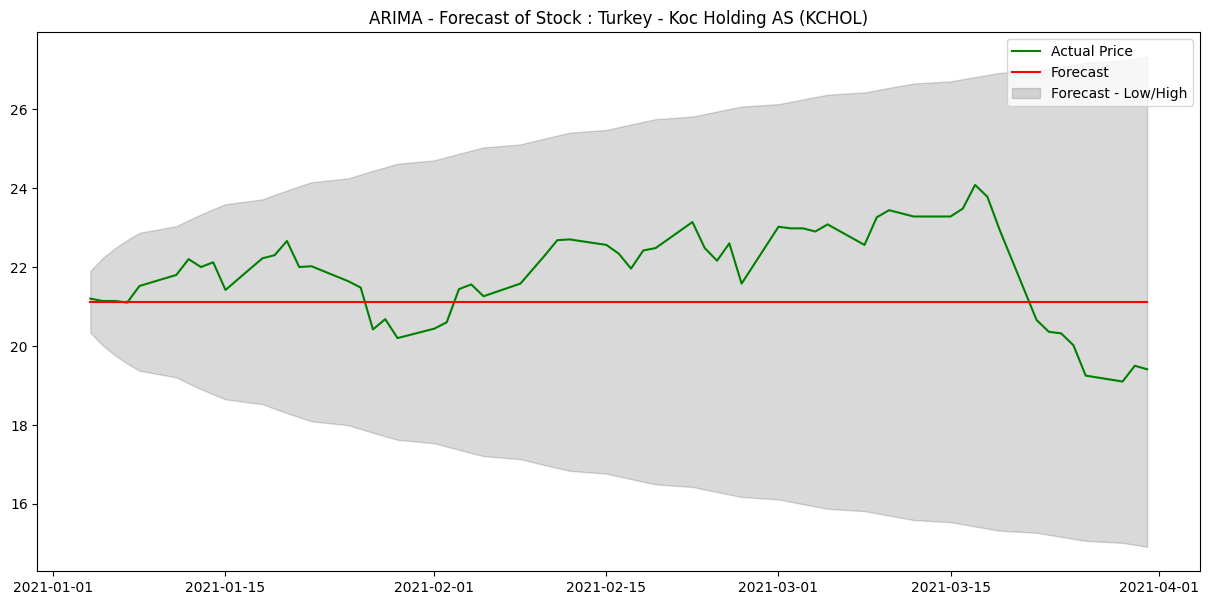

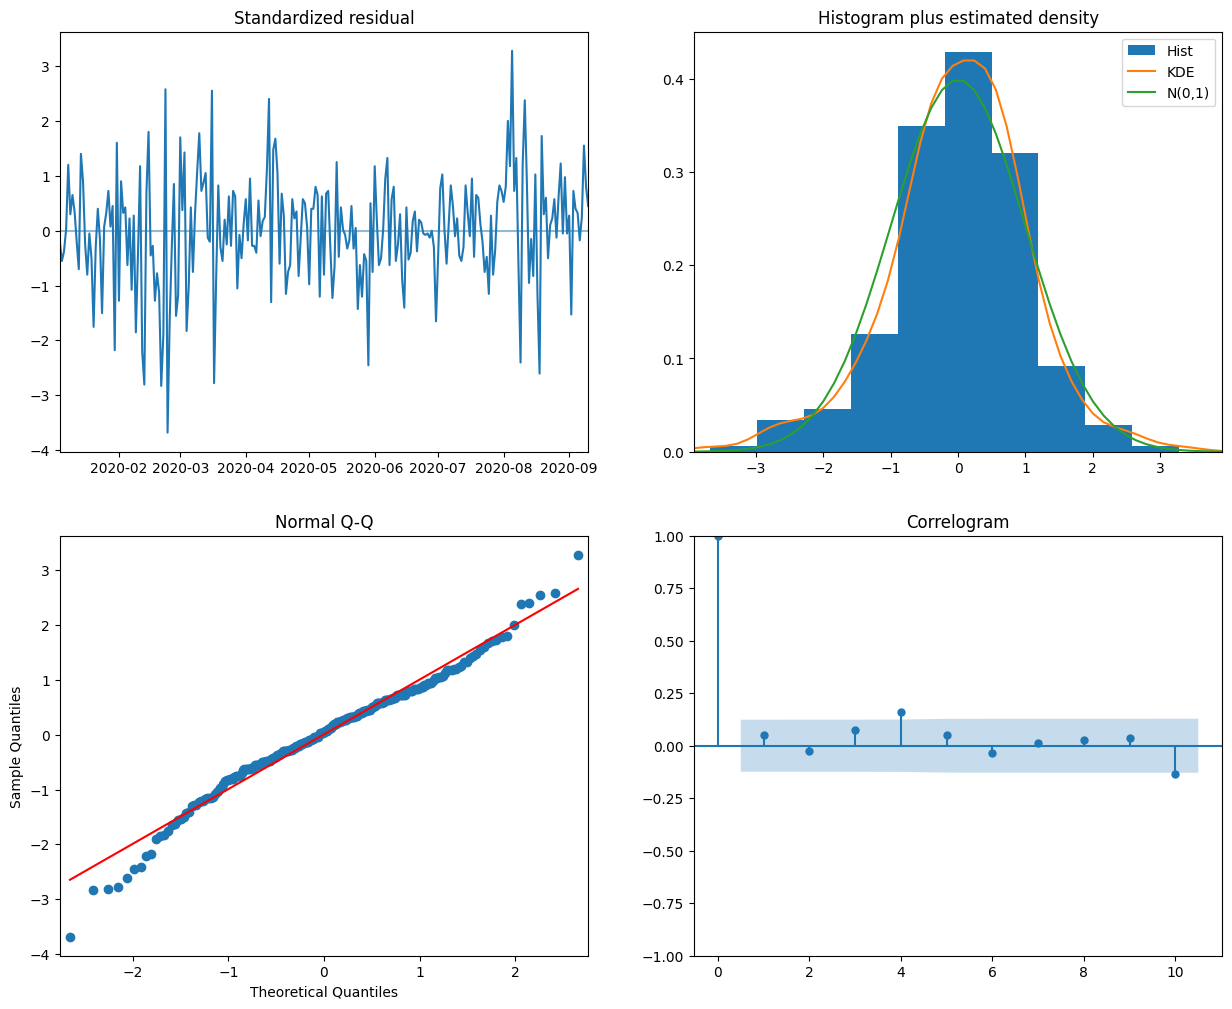

Test Statistic : -1.5424176782779746
p-value : 0.5124333991631933
#Lags Used : 1
Number of Observations Used : 241
The series is NOT stationary
Egypt - Medinet Nasr Housing (M
ARIMA Order: (1, 1, 0)


Mean Absolute Percentage Error (MAPE): 2.51%


<Figure size 640x480 with 0 Axes>

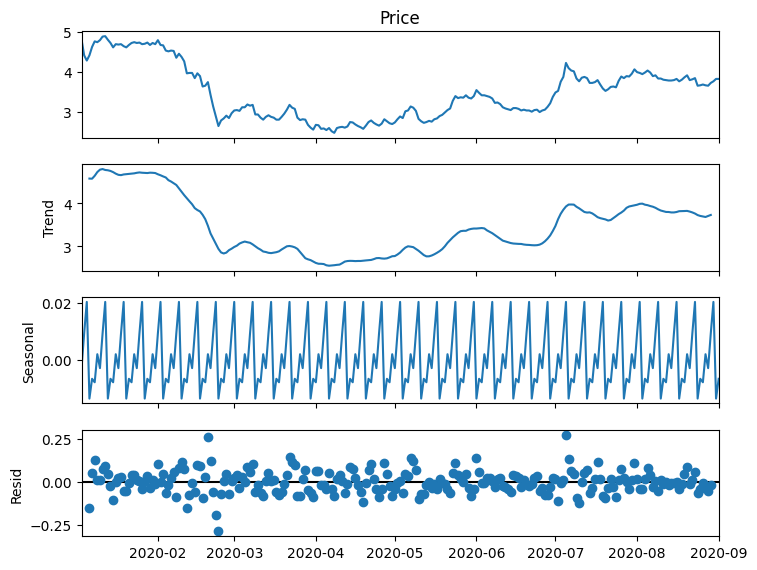

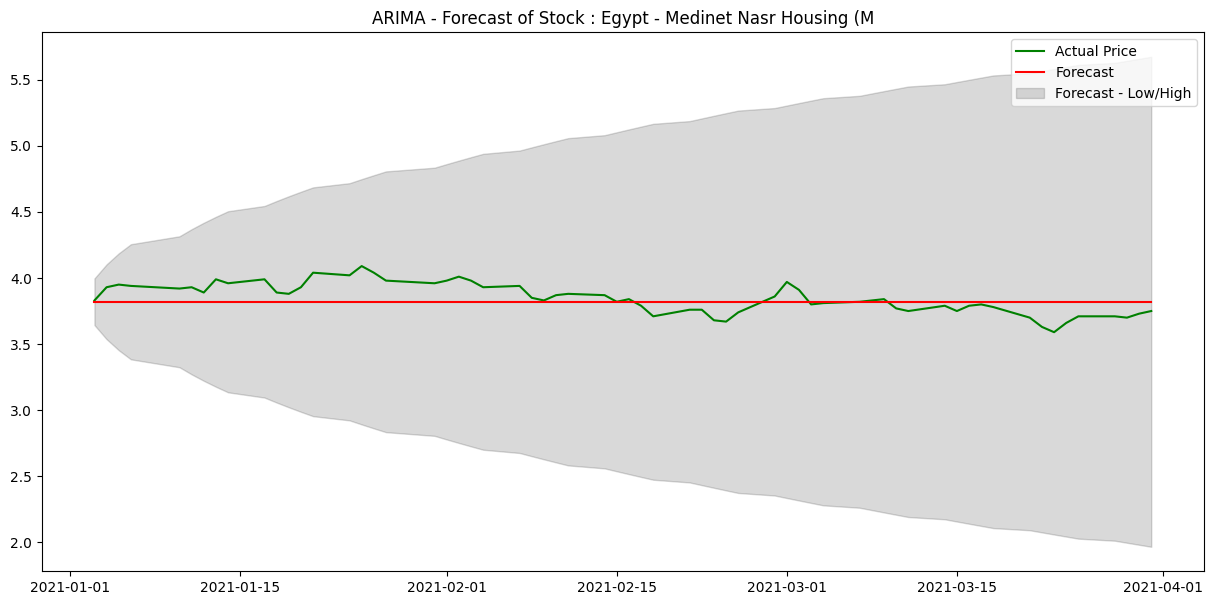

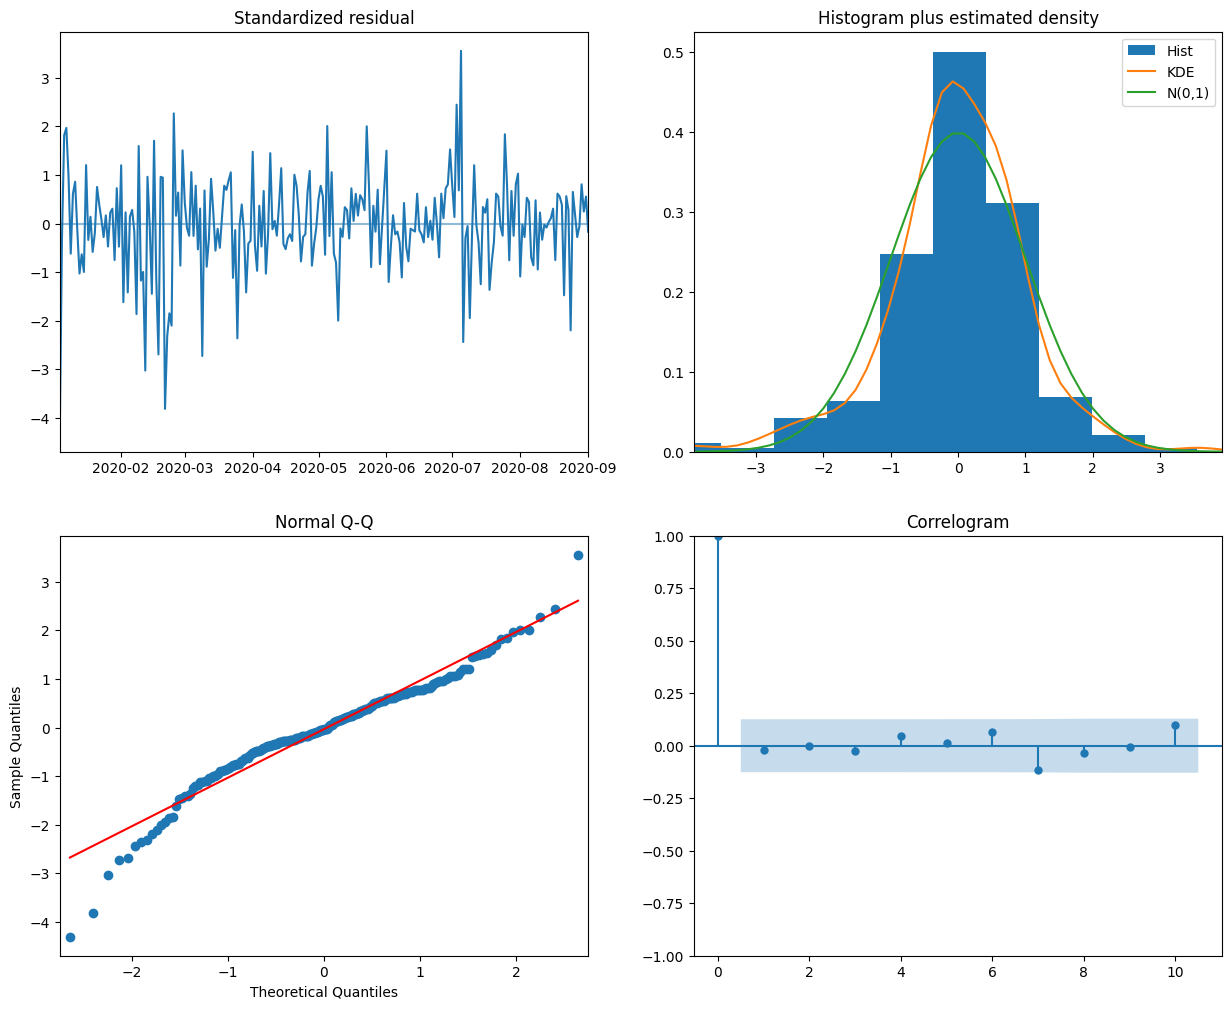

Test Statistic : -2.1956983927966993
p-value : 0.20781039501227272
#Lags Used : 3
Number of Observations Used : 245
The series is NOT stationary
Brazil - Minerva SABrazil (BEEF
ARIMA Order: (0, 1, 0)


Mean Absolute Percentage Error (MAPE): 5.66%


<Figure size 640x480 with 0 Axes>

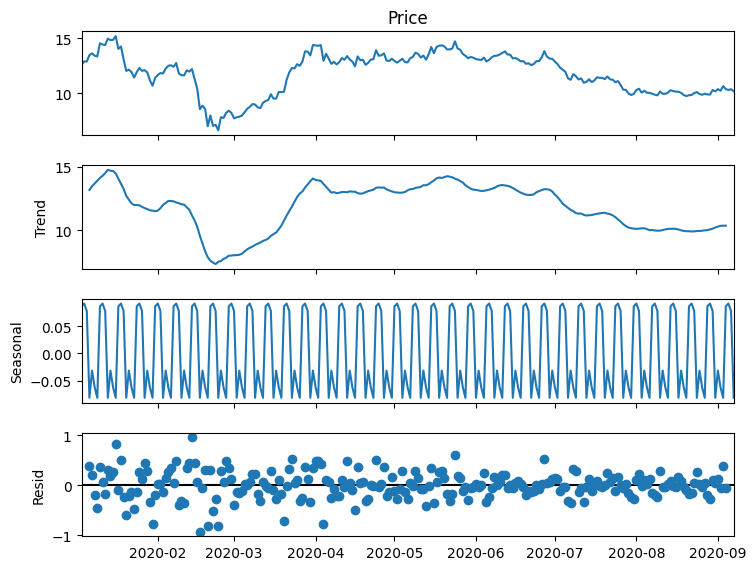

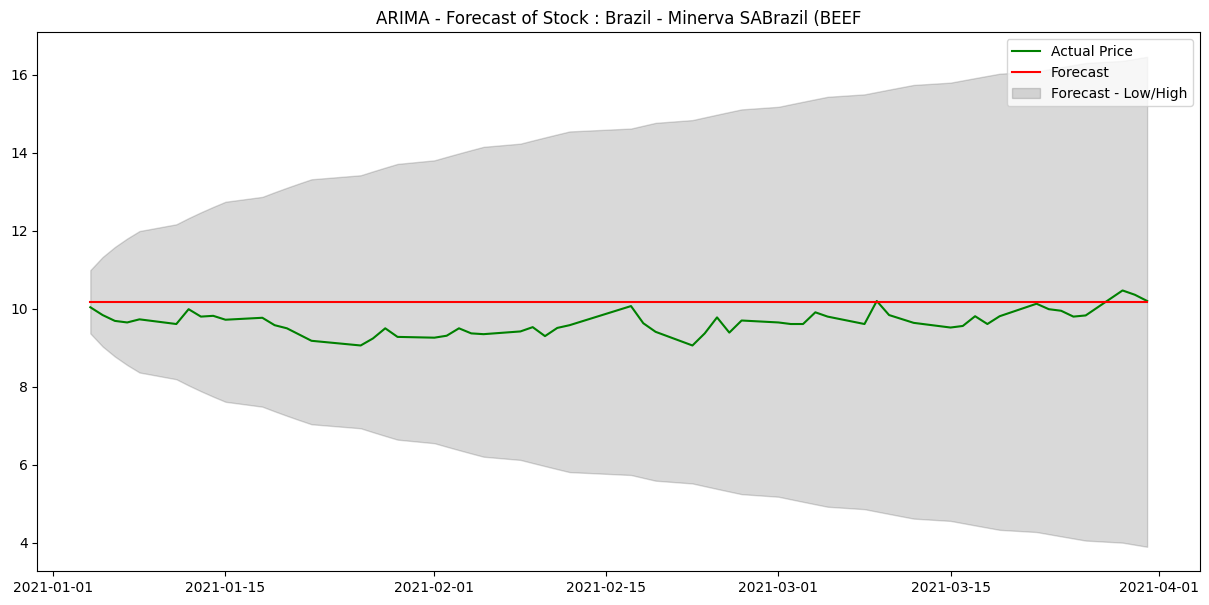

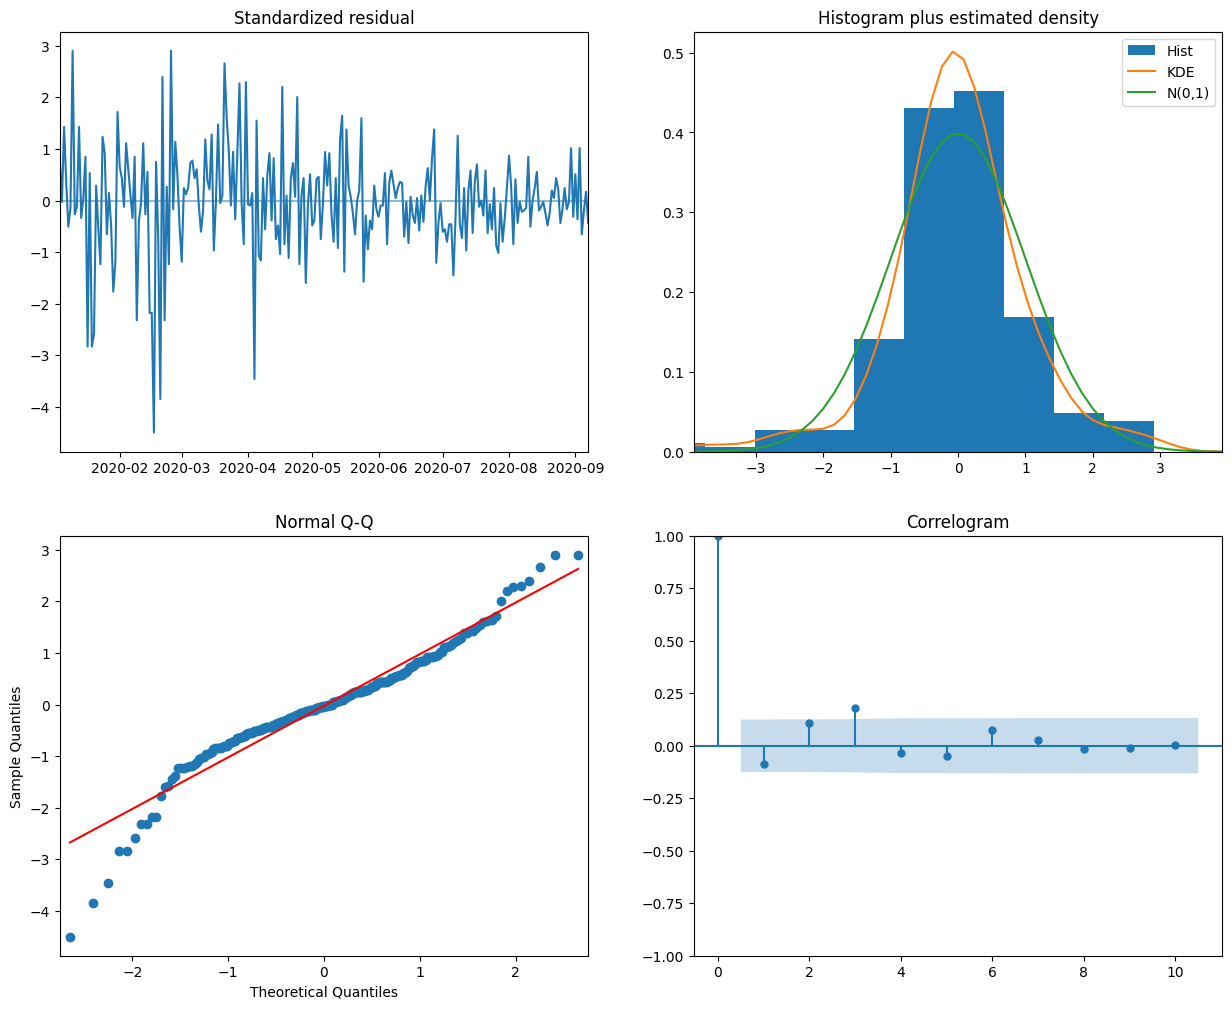

Test Statistic : -0.7426681664185703
p-value : 0.8353858829030216
#Lags Used : 0
Number of Observations Used : 239
The series is NOT stationary
Argentina - Pampa Energia SA (P
ARIMA Order: (0, 1, 0)


Mean Absolute Percentage Error (MAPE): 6.20%


<Figure size 640x480 with 0 Axes>

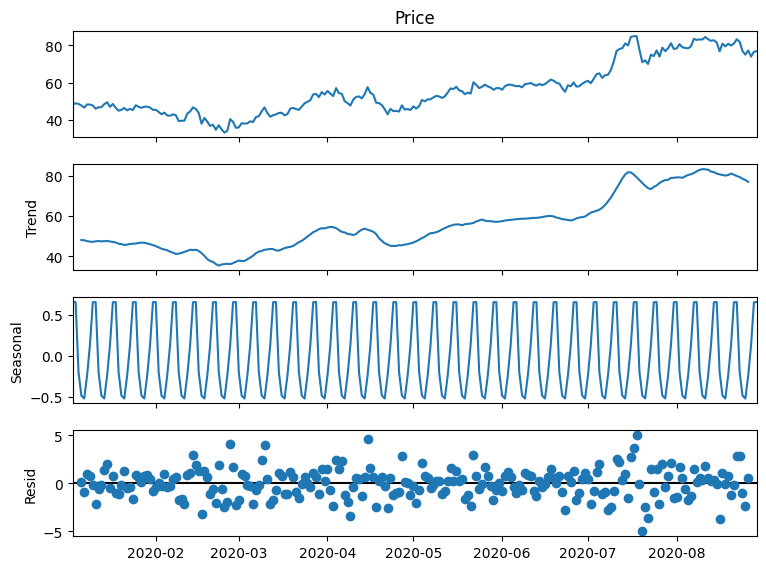

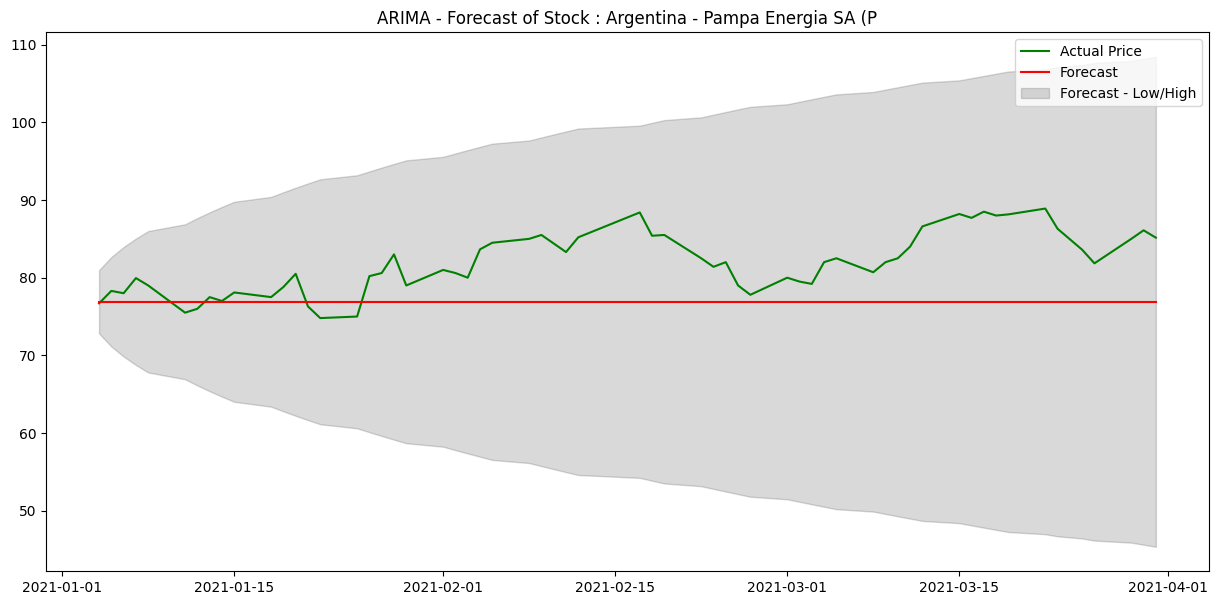

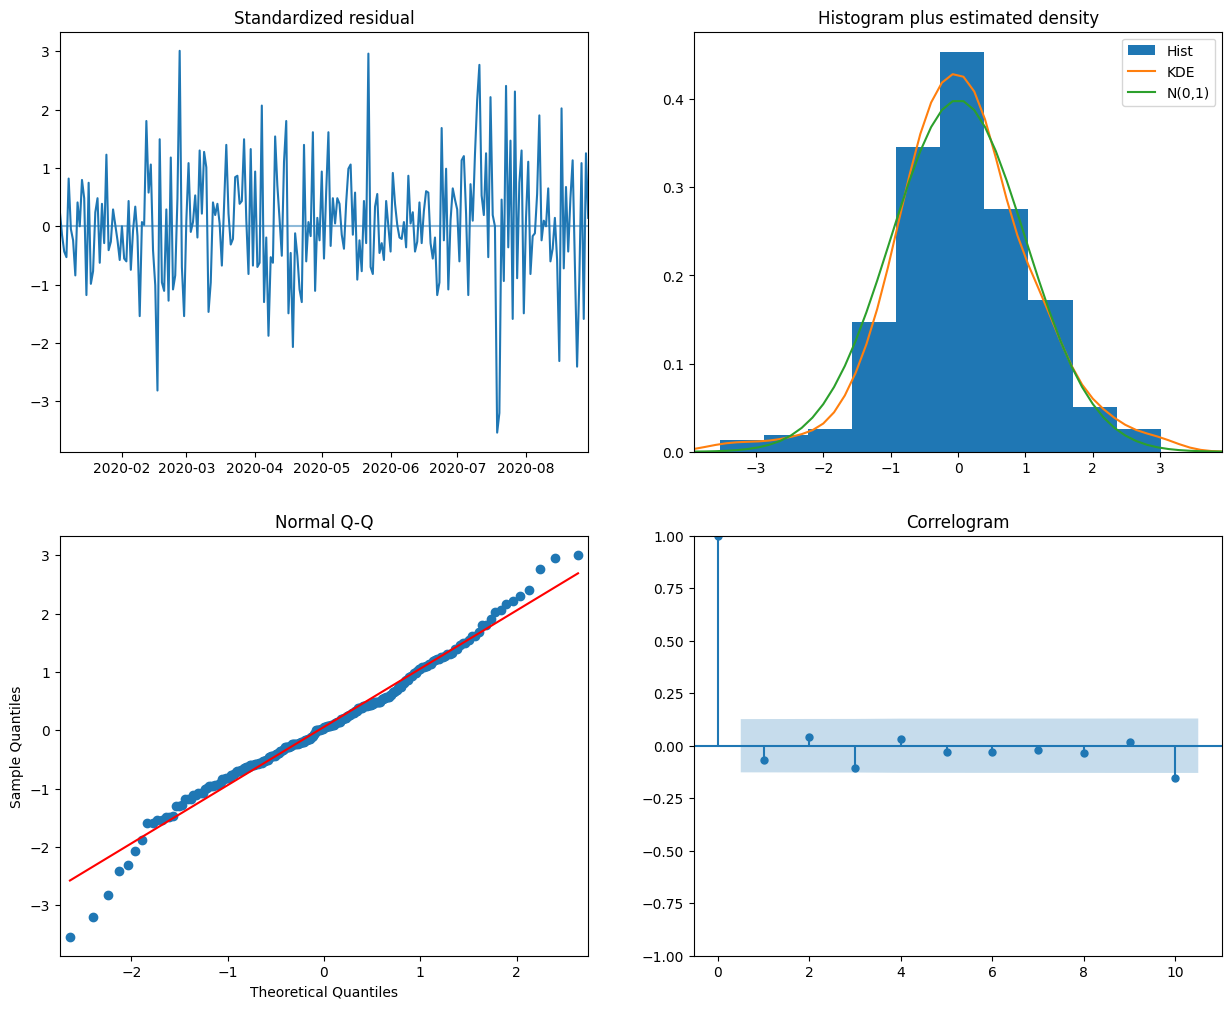

Test Statistic : -1.8521235185530325
p-value : 0.35490774277987824
#Lags Used : 5
Number of Observations Used : 236
The series is NOT stationary
Colombia - Cementos Argos SA (C
ARIMA Order: (0, 1, 0)


Mean Absolute Percentage Error (MAPE): 9.81%


<Figure size 640x480 with 0 Axes>

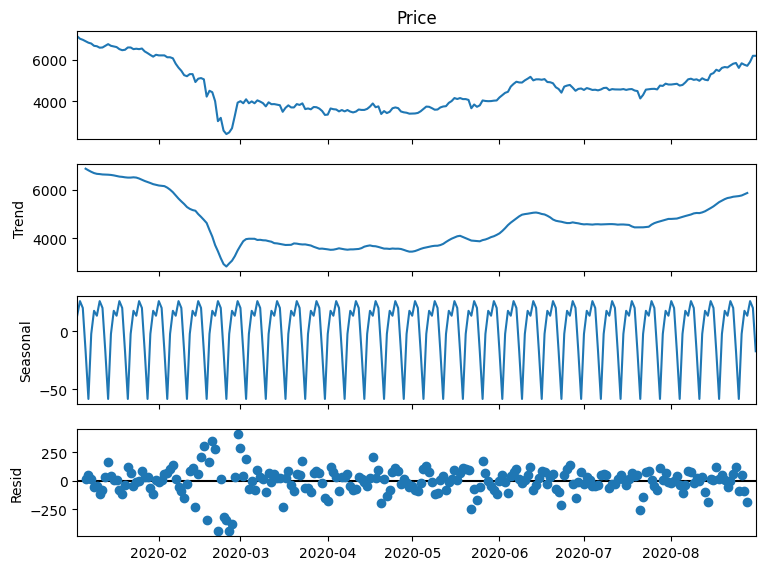

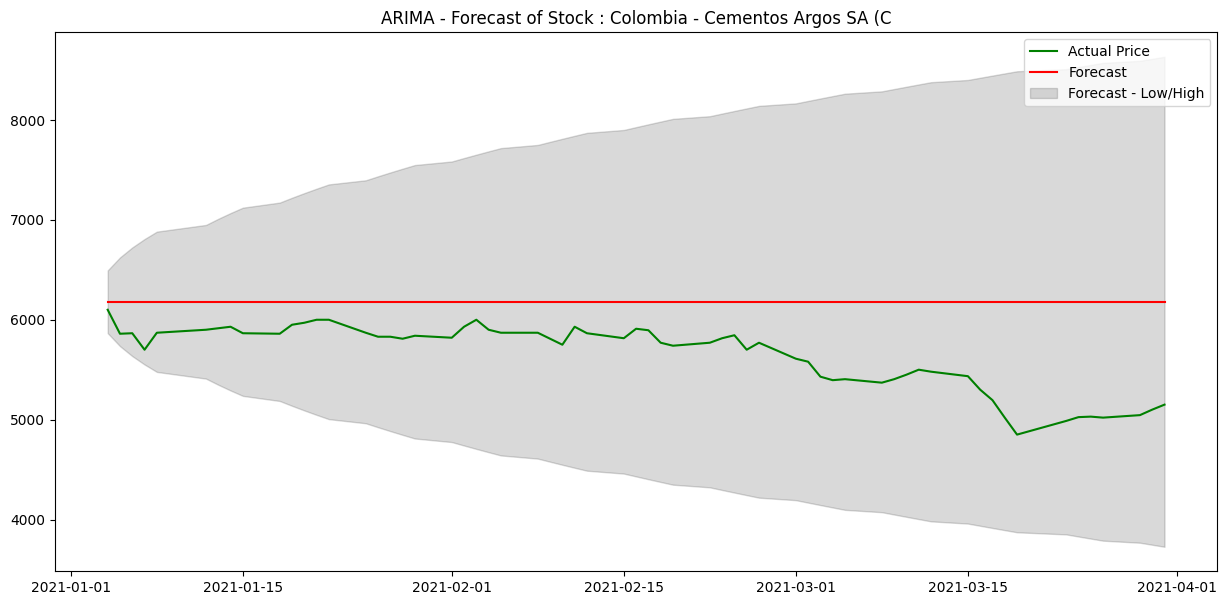

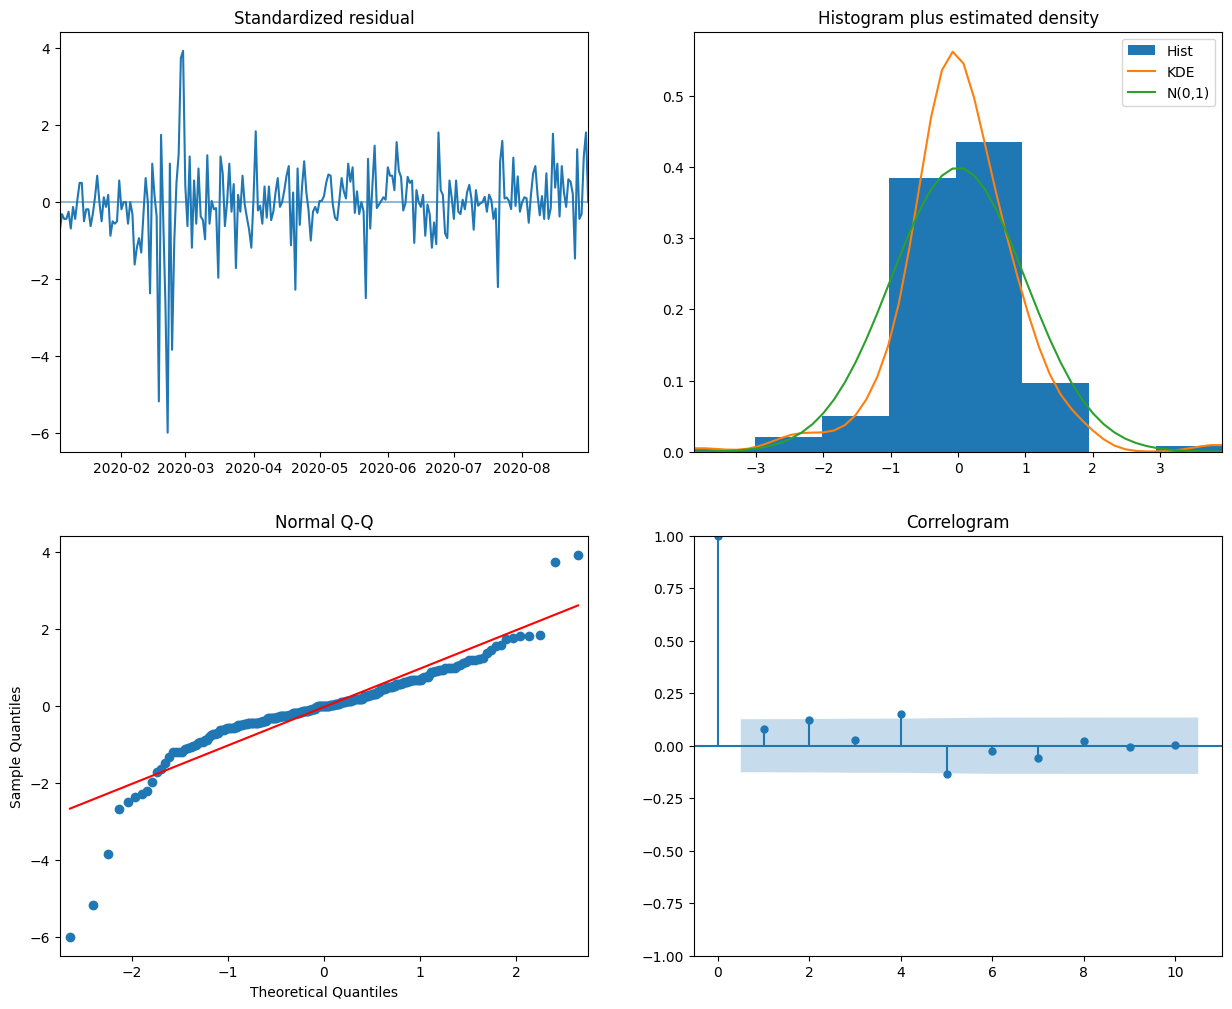

Test Statistic : -0.910445838788536
p-value : 0.7845129916264035
#Lags Used : 6
Number of Observations Used : 245
The series is NOT stationary
South Africa - Impala Platinum 
ARIMA Order: (0, 1, 0)


Mean Absolute Percentage Error (MAPE): 13.90%


<Figure size 640x480 with 0 Axes>

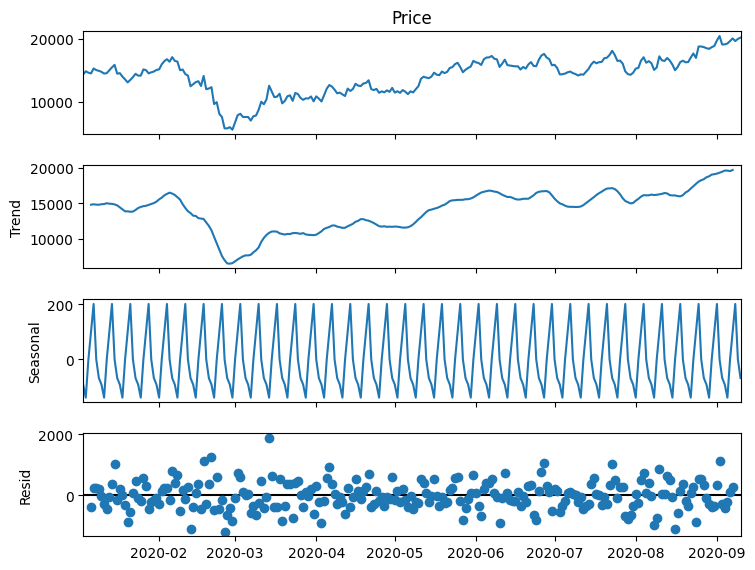

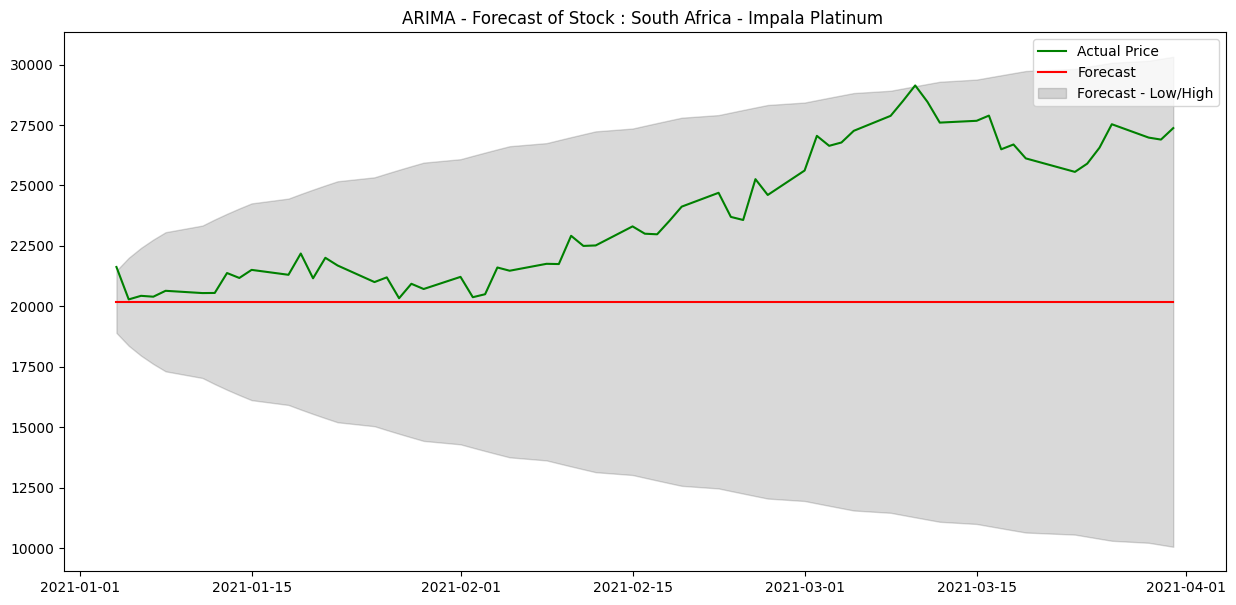

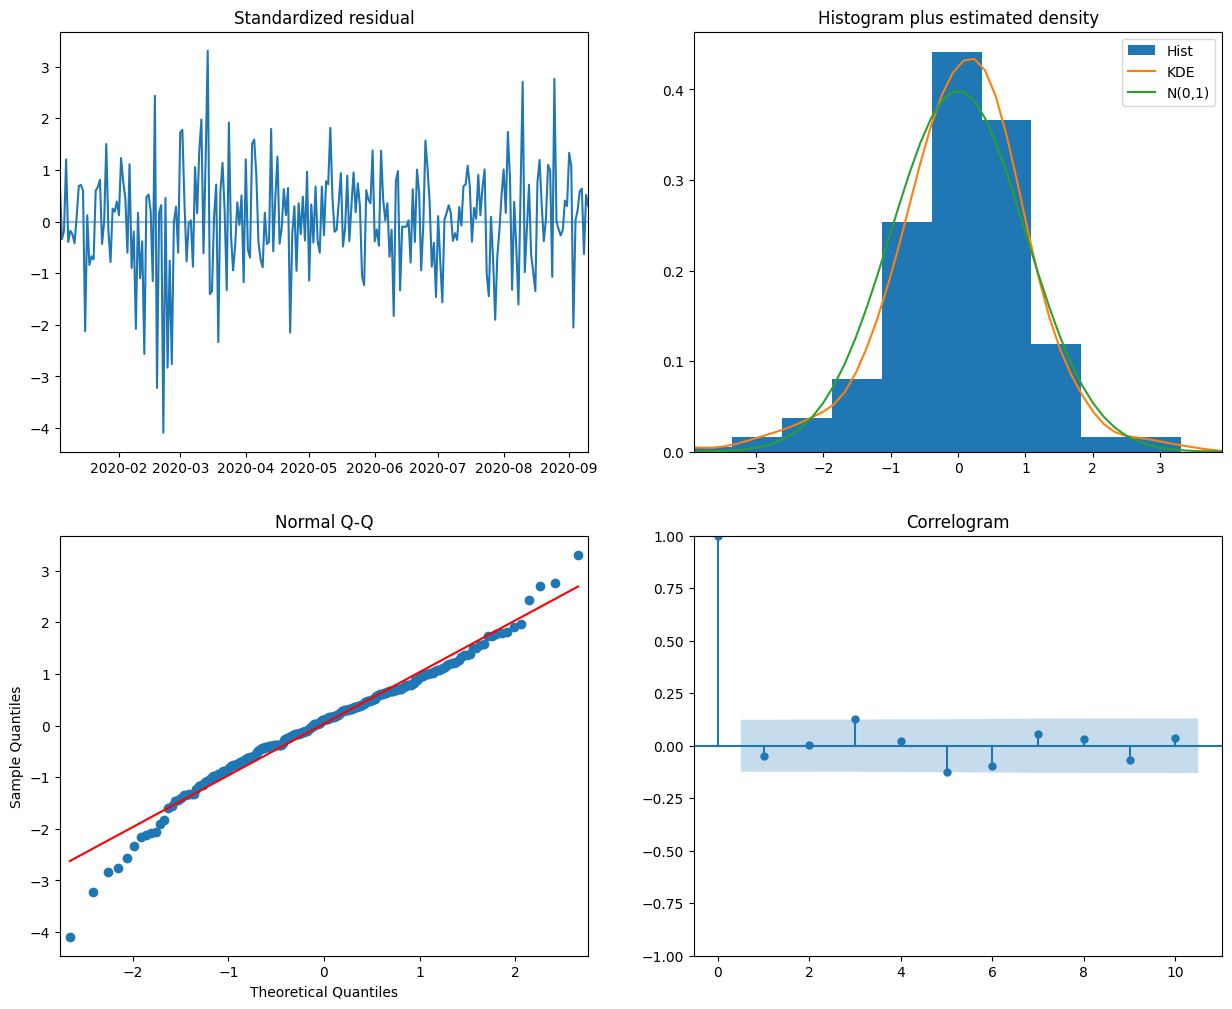

Test Statistic : -0.7325649461744608
p-value : 0.8381332296792271
#Lags Used : 0
Number of Observations Used : 271
The series is NOT stationary
South Korea - Dongkuk Steel Mil
ARIMA Order: (0, 1, 0)


Mean Absolute Percentage Error (MAPE): 13.10%


<Figure size 640x480 with 0 Axes>

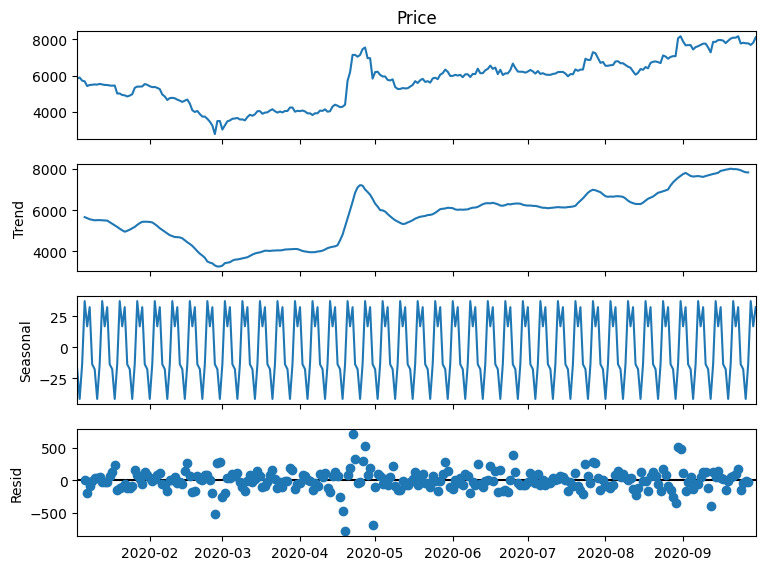

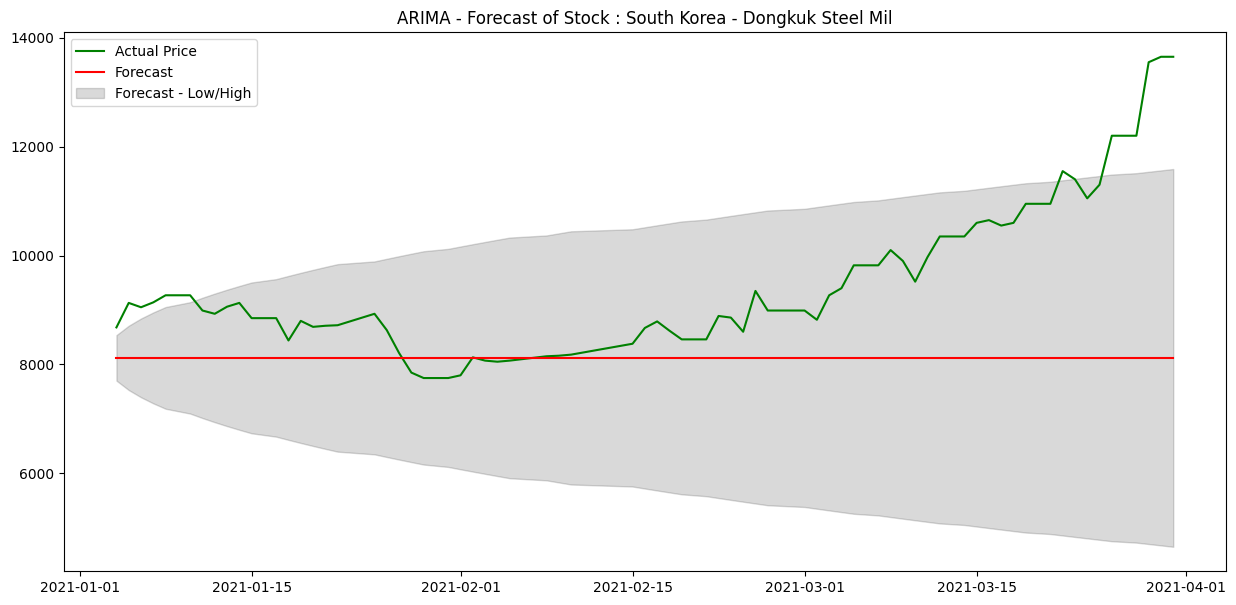

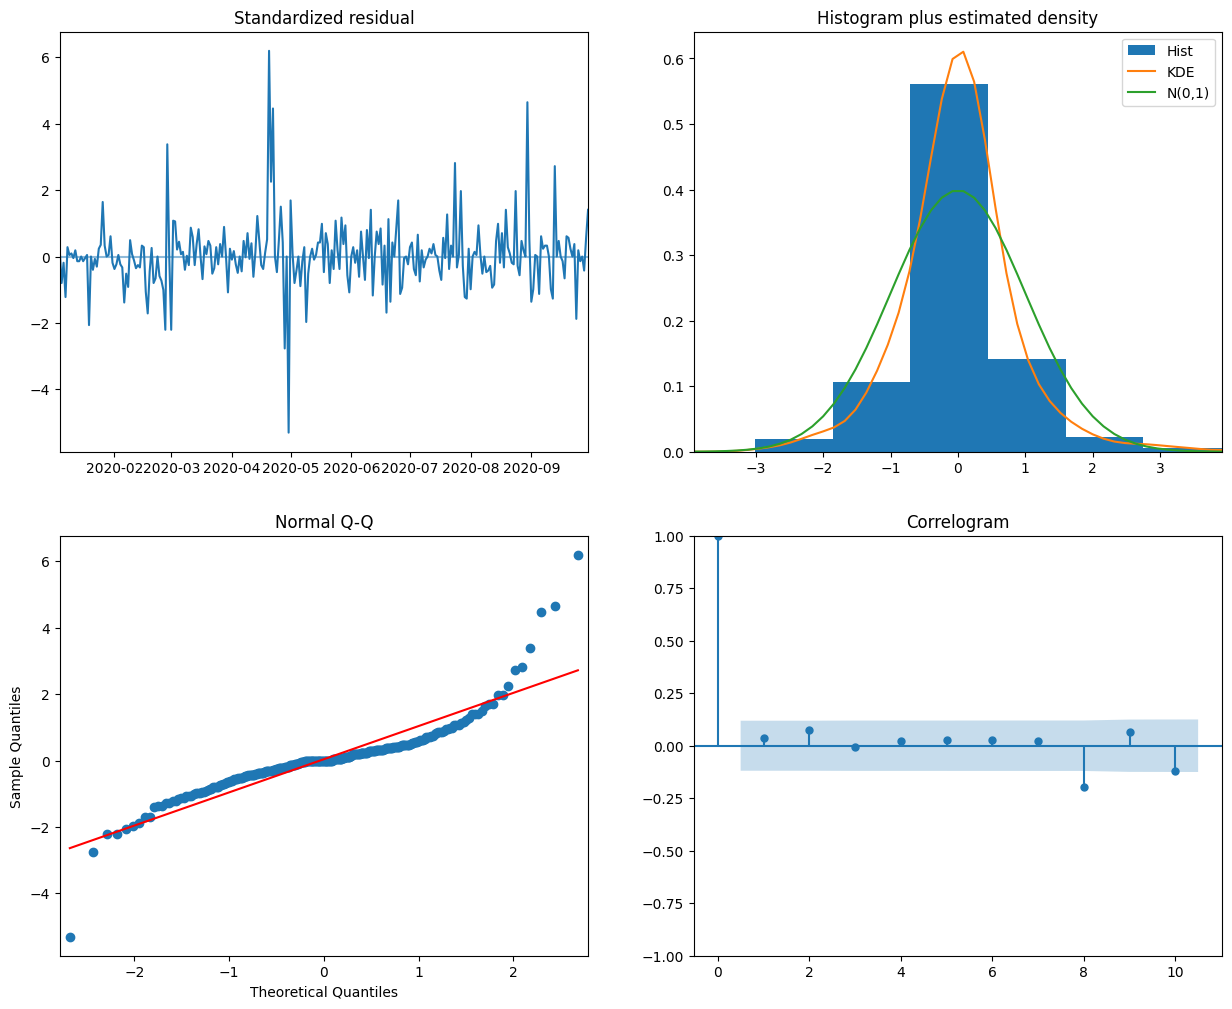

In [11]:
for key in df_dic:
    train_ARIMA, test_ARIMA, train_index, forecast_index = ARIMA_prerun(df_dic[key])
    print(key)
    ARIMA_model,forecast_df = ARIMA_forecast(train_ARIMA, test_ARIMA, train_index, forecast_index,name=key)
    ARIMA_model.plot_diagnostics(figsize=(15,12))
    plt.show()

ARIMA performs generally well with linear trends and stationary time series detecting also seasonality. It is less efficient with not linear trend making it unsuitable for forecasting complex trends like  stock prices.

### Forecasting with LSTM

In [20]:

K.clear_session()
scaler =  MinMaxScaler()

#prepraing the data for LSTM model

def df_to_X_y(df, window_size):
  X = []
  y = []
  for i in range(len(df)-window_size):
    row = df[i:i+window_size]
    X.append(row)
    label = df[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)


#bulding and training LSTM model

def lstm(df,name):

    window_size = 5

    #scaling the datasent
    scaled = scaler.fit_transform(df[['Price']])
    # test_LSTM_scaled = scaler.transform(df.loc['2021',['Price']])

    #converting to tensors
    X1, y1, = df_to_X_y(scaled,window_size)
    # X_test, y_test = df_to_X_y(test_LSTM_scaled,window_size)

    #spliting train and val set
    # train_len = len(df[df.index.year == 2020])
    # val_len = int((1-.2) * train_len)
    # test_len = len(df[df.index.year == 2021])

    train_len = len(df[df.index.year == 2020]) - window_size
    val_len = int((1 - 0.2) * train_len)
    # test_len = len(df[df.index.year == 2021])

    X_train, y_train = X1[:val_len], y1[:val_len]
    X_val, y_val = X1[val_len:train_len], y1[val_len:train_len]
    X_test, y_test = X1[train_len:], y1[train_len:]



    #shapes
    print("scaled price dataset",scaled.shape)
    print("scaled tensor",X1.shape, y1.shape)
    print("training",X_train.shape, y_train.shape)
    print("validation",X_val.shape, y_val.shape)
    print("test",X_test.shape, y_test.shape)

    #bulding the LSTM model
    model_lstm = Sequential()
    model_lstm.add(InputLayer((5, 1)))
    model_lstm.add(LSTM(64))
    model_lstm.add(Dense(1, 'linear'))
    model_lstm.summary()

    model_lstm.compile(loss=MeanSquaredError(), optimizer='adam', metrics=[RootMeanSquaredError()])

    cp = ModelCheckpoint('model_lstm.keras', save_best_only=True)

    #model fitting
    model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[cp])

    #recalling the best model
    model_lstm_best = load_model('model_lstm.keras')

    #forecast
    test_predictions = model_lstm_best.predict(X_test).flatten()

    # Inverse transform to the original scale
    y_test_original_scale = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    predictions_original_scale = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

    original_index = df.loc['2021', 'Price'].index

    test_results = pd.DataFrame(data={'Test_Predictions': predictions_original_scale, 'Actuals': y_test_original_scale}, index=original_index)
    test_results.index = pd.to_datetime(test_results.index)

    test_results['APE'] = np.abs((test_results['Actuals'] - test_results['Test_Predictions']) / test_results['Actuals']) * 100
    mape_forecast = np.mean(test_results['APE'])
    print(f"MAPE: {mape_forecast:.2f}%")

    # Plotting
    plt.figure(figsize=(15, 7))
    plt.plot(test_results['Actuals'], color='Green', label="Actual Price")
    plt.plot(test_results['Test_Predictions'], color='red', label="Forecast")
    plt.title(f"LSTM - Forecast of Stock : {name}")
    plt.legend()
    plt.show()
    model_lstm_best.save(f"{name}_model.keras")
    return model_lstm_best,test_results


In [21]:
lstm_model = {}  # Empty dictionary
forecast_lstm ={}

Russia - Sberbank Rossii PAO (S
scaled price dataset (311, 1)
scaled tensor (306, 5, 1) (306, 1)
training (196, 5, 1) (196, 1)
validation (49, 5, 1) (49, 1)
test (61, 5, 1) (61, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.2178 - root_mean_squared_error: 0.4665 - val_loss: 0.3981 - val_root_mean_squared_error: 0.6310
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1116 - root_mean_squared_error: 0.3339 - val_loss: 0.2251 - val_root_mean_squared_error: 0.4744
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0638 - root_mean_squared_error: 0.2510 - val_loss: 0.0868 - val_root_mean_squared_error: 0.2947
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0196 - root_mean_squared_error: 0.1393 - val_loss: 0.0202 - val_root_mean_squared_error: 0.1422
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0159 - root_mean_squared_error: 0.1262 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1123
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0145 - root_mean_squared_error: 0.1202 - val_loss: 0.0232 - val_root_mean_squared_error: 0.1524
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0115 - root_mean

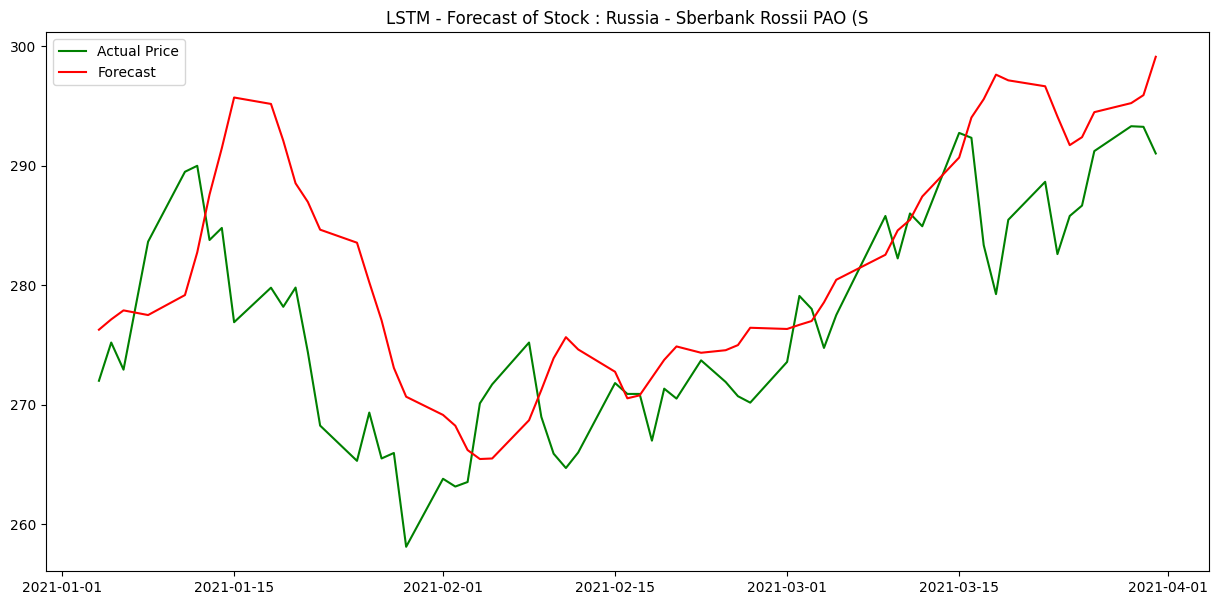

Turkey - Koc Holding AS (KCHOL)
scaled price dataset (315, 1)
scaled tensor (310, 5, 1) (310, 1)
training (197, 5, 1) (197, 1)
validation (50, 5, 1) (50, 1)
test (63, 5, 1) (63, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1144 - root_mean_squared_error: 0.3378 - val_loss: 0.1250 - val_root_mean_squared_error: 0.3535
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0500 - root_mean_squared_error: 0.2233 - val_loss: 0.0470 - val_root_mean_squared_error: 0.2167
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0142 - root_mean_squared_error: 0.1189 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1001
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0094 - root_mean_squared_error: 0.0969 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0809
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0114 - root_mean_squared_error: 0.1067 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0891
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0065 - root_mean_squared_error: 0.0809 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1157
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0061 - root_mean_

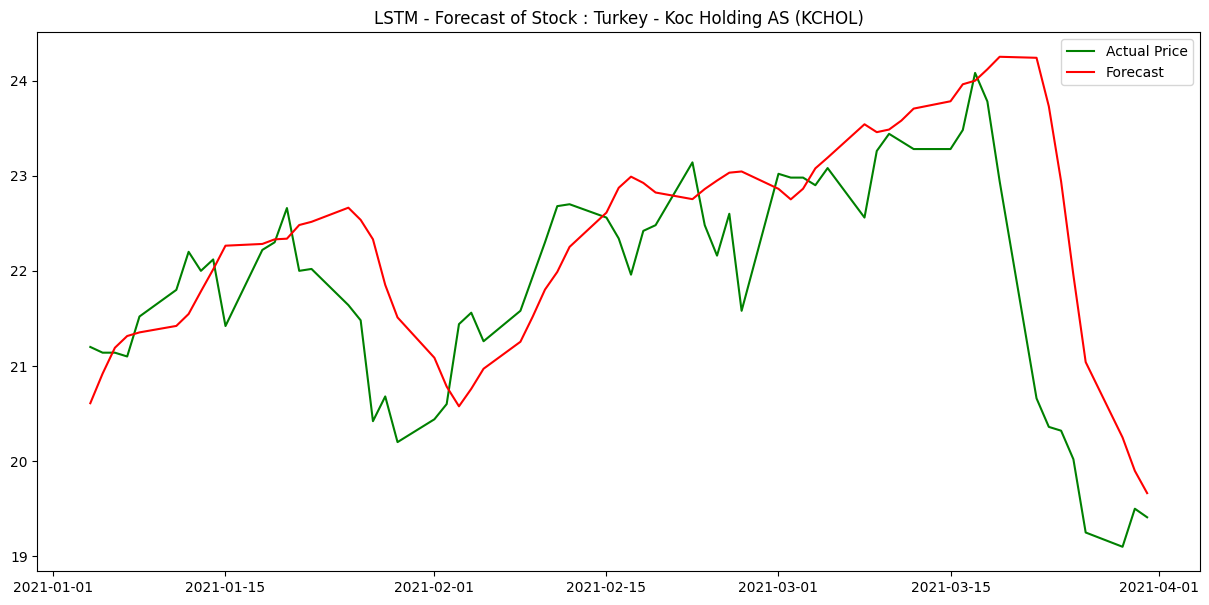

Egypt - Medinet Nasr Housing (M
scaled price dataset (305, 1)
scaled tensor (300, 5, 1) (300, 1)
training (190, 5, 1) (190, 1)
validation (48, 5, 1) (48, 1)
test (62, 5, 1) (62, 1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.1965 - root_mean_squared_error: 0.4401 - val_loss: 0.1391 - val_root_mean_squared_error: 0.3729
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0948 - root_mean_squared_error: 0.3067 - val_loss: 0.0498 - val_root_mean_squared_error: 0.2233
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0351 - root_mean_squared_error: 0.1866 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0649
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0160 - root_mean_squared_error: 0.1262 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0799
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0201 - root_mean_squared_error: 0.1417 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0592
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0137 - root_mean_squared_error: 0.1169 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0489
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0100 - root_me

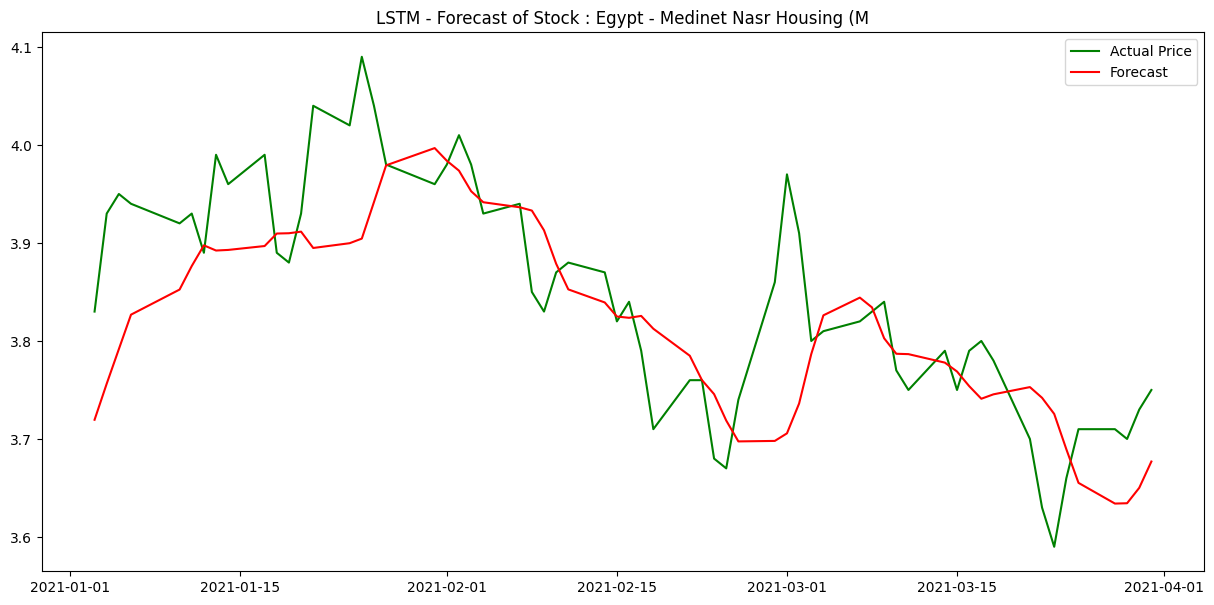

Brazil - Minerva SABrazil (BEEF
scaled price dataset (309, 1)
scaled tensor (304, 5, 1) (304, 1)
training (195, 5, 1) (195, 1)
validation (49, 5, 1) (49, 1)
test (60, 5, 1) (60, 1)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.3600 - root_mean_squared_error: 0.5994 - val_loss: 0.0581 - val_root_mean_squared_error: 0.2411
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1488 - root_mean_squared_error: 0.3849 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0733
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0284 - root_mean_squared_error: 0.1675 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1156
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0187 - root_mean_squared_error: 0.1361 - val_loss: 0.0276 - val_root_mean_squared_error: 0.1661
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0192 - root_mean_squared_error: 0.1384 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0924
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0109 - root_mean_squared_error: 0.1041 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0462
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0101 - root_mean_

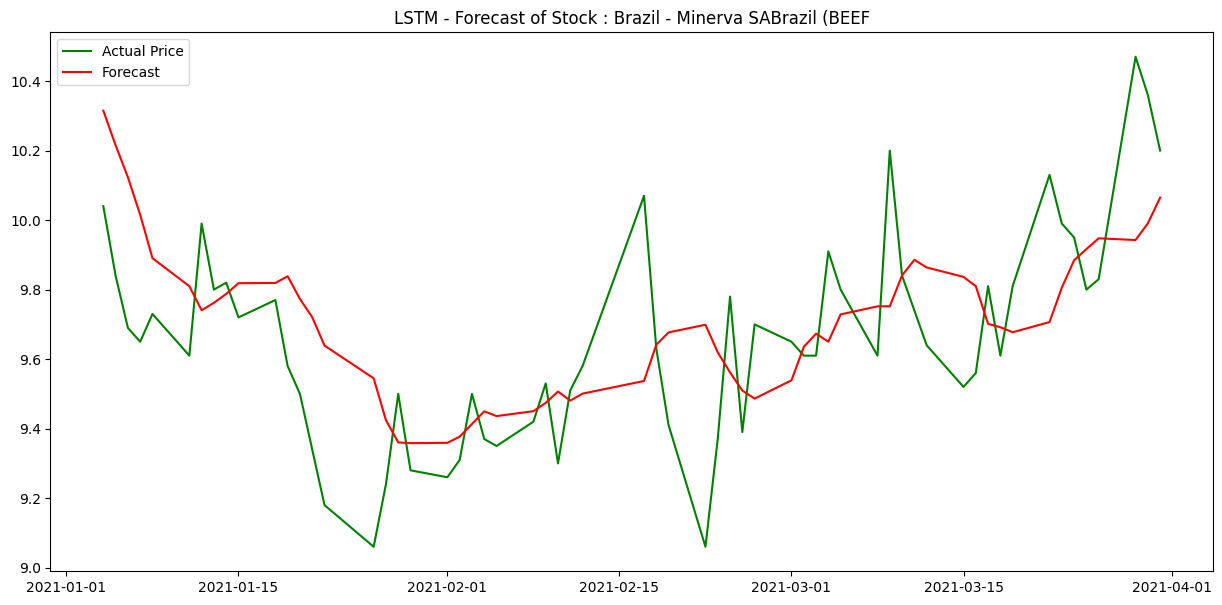

Argentina - Pampa Energia SA (P
scaled price dataset (300, 1)
scaled tensor (295, 5, 1) (295, 1)
training (188, 5, 1) (188, 1)
validation (47, 5, 1) (47, 1)
test (60, 5, 1) (60, 1)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.1279 - root_mean_squared_error: 0.3574 - val_loss: 0.5480 - val_root_mean_squared_error: 0.7403
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0689 - root_mean_squared_error: 0.2622 - val_loss: 0.3003 - val_root_mean_squared_error: 0.5480
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0257 - root_mean_squared_error: 0.1600 - val_loss: 0.1125 - val_root_mean_squared_error: 0.3355
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0100 - root_mean_squared_error: 0.1002 - val_loss: 0.0226 - val_root_mean_squared_error: 0.1504
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0131 - root_mean_squared_error: 0.1143 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1375
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0098 - root_mean_squared_error: 0.0988 - val_loss: 0.0419 - val_root_mean_squared_error: 0.2048
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0076 - root_mean

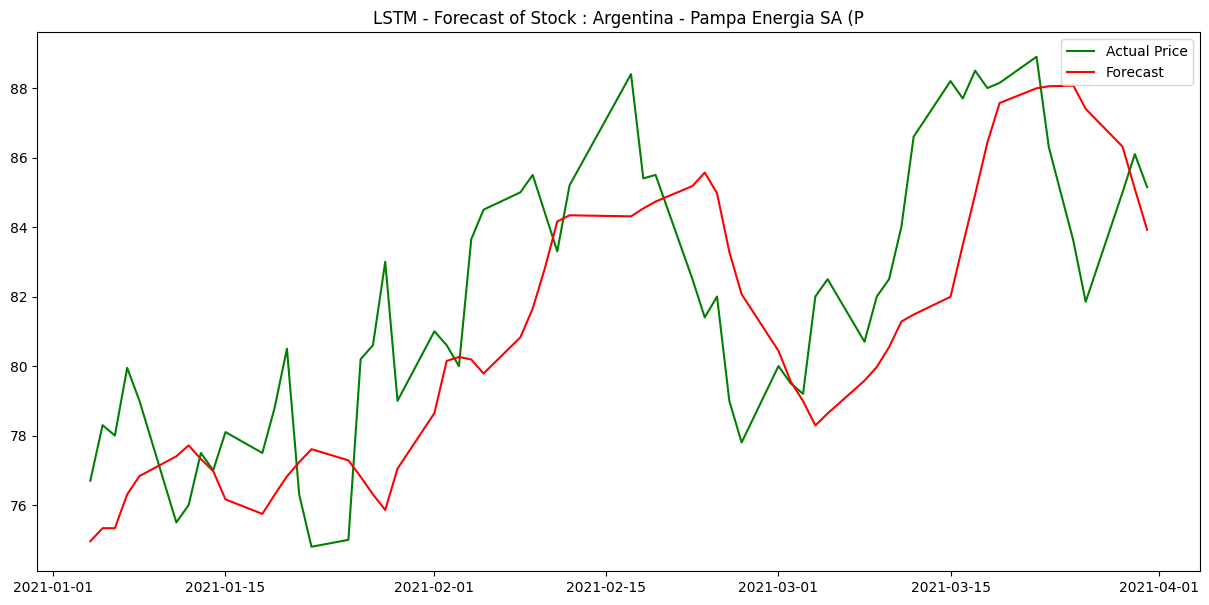

Colombia - Cementos Argos SA (C
scaled price dataset (303, 1)
scaled tensor (298, 5, 1) (298, 1)
training (189, 5, 1) (189, 1)
validation (48, 5, 1) (48, 1)
test (61, 5, 1) (61, 1)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.3128 - root_mean_squared_error: 0.5583 - val_loss: 0.2868 - val_root_mean_squared_error: 0.5356
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1914 - root_mean_squared_error: 0.4362 - val_loss: 0.1468 - val_root_mean_squared_error: 0.3832
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0846 - root_mean_squared_error: 0.2893 - val_loss: 0.0481 - val_root_mean_squared_error: 0.2193
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0241 - root_mean_squared_error: 0.1543 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0683
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0145 - root_mean_squared_error: 0.1196 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0712
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0181 - root_mean_squared_error: 0.1345 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0525
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0135 - root_mean_

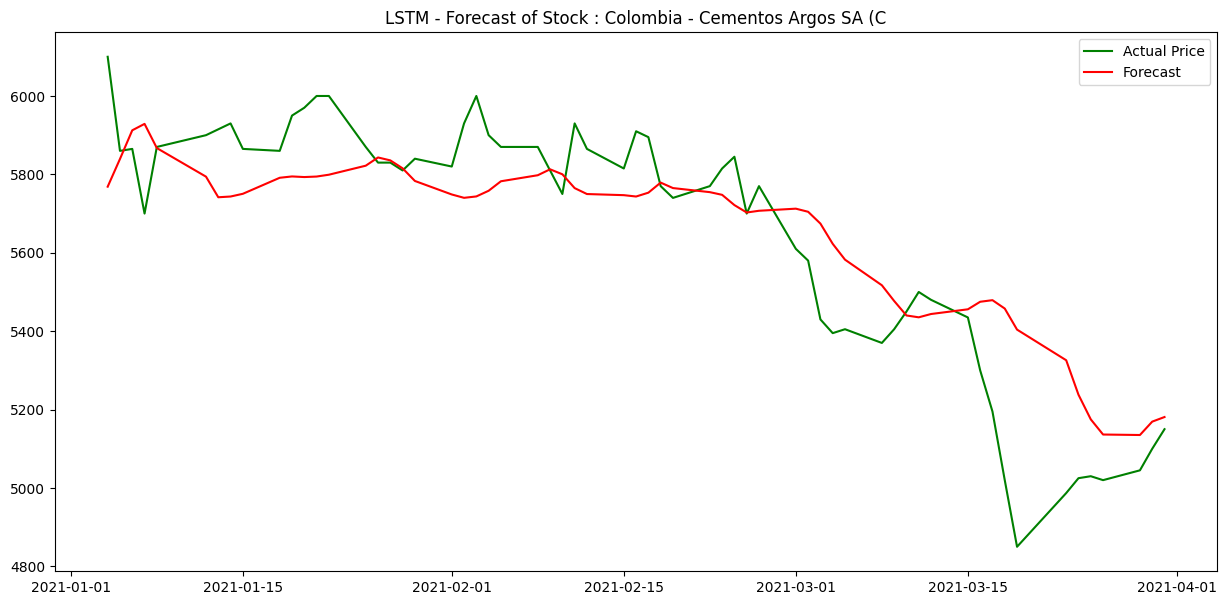

South Africa - Impala Platinum 
scaled price dataset (314, 1)
scaled tensor (309, 5, 1) (309, 1)
training (197, 5, 1) (197, 1)
validation (50, 5, 1) (50, 1)
test (62, 5, 1) (62, 1)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.1051 - root_mean_squared_error: 0.3236 - val_loss: 0.1174 - val_root_mean_squared_error: 0.3427
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0379 - root_mean_squared_error: 0.1942 - val_loss: 0.0315 - val_root_mean_squared_error: 0.1774
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - root_mean_squared_error: 0.0834 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0486
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - root_mean_squared_error: 0.0857 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0467
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - root_mean_squared_error: 0.0821 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0689
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - root_mean_squared_error: 0.0574 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1047
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - root_mean_

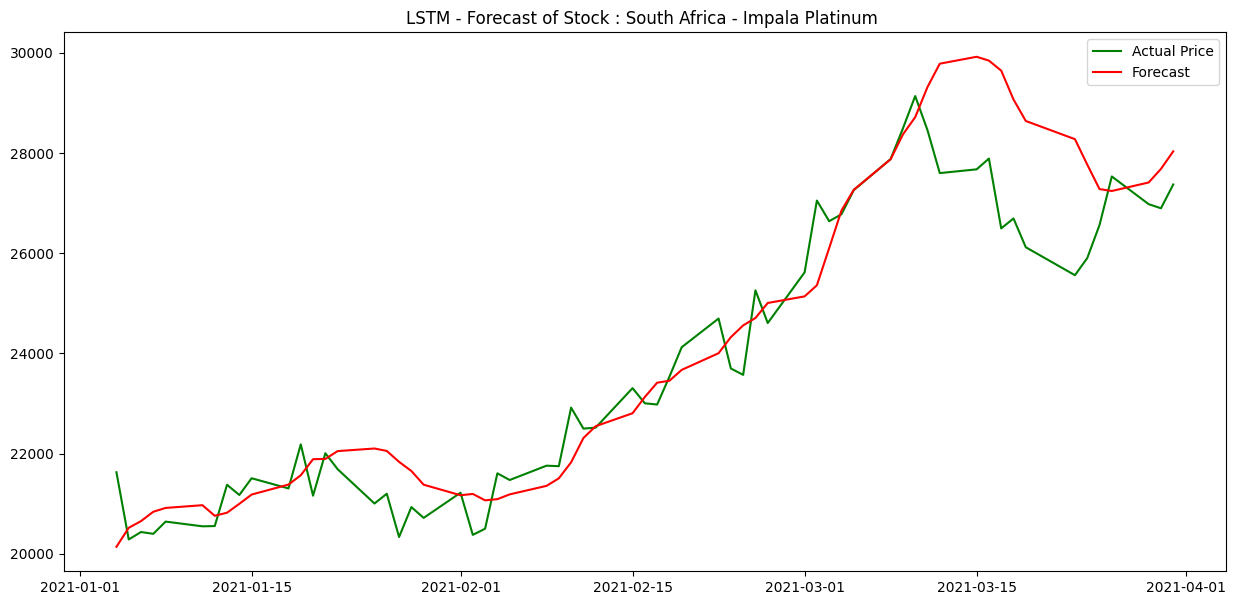

South Korea - Dongkuk Steel Mil
scaled price dataset (341, 1)
scaled tensor (336, 5, 1) (336, 1)
training (213, 5, 1) (213, 1)
validation (54, 5, 1) (54, 1)
test (69, 5, 1) (69, 1)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0351 - root_mean_squared_error: 0.1865 - val_loss: 0.0376 - val_root_mean_squared_error: 0.1938
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0073 - root_mean_squared_error: 0.0846 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0528
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - root_mean_squared_error: 0.0602 - val_loss: 7.7629e-04 - val_root_mean_squared_error: 0.0279
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - root_mean_squared_error: 0.0613 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0595
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023 - root_mean_squared_error: 0.0475 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0894
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - root_mean_squared_error: 0.0480 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0784
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - root_m

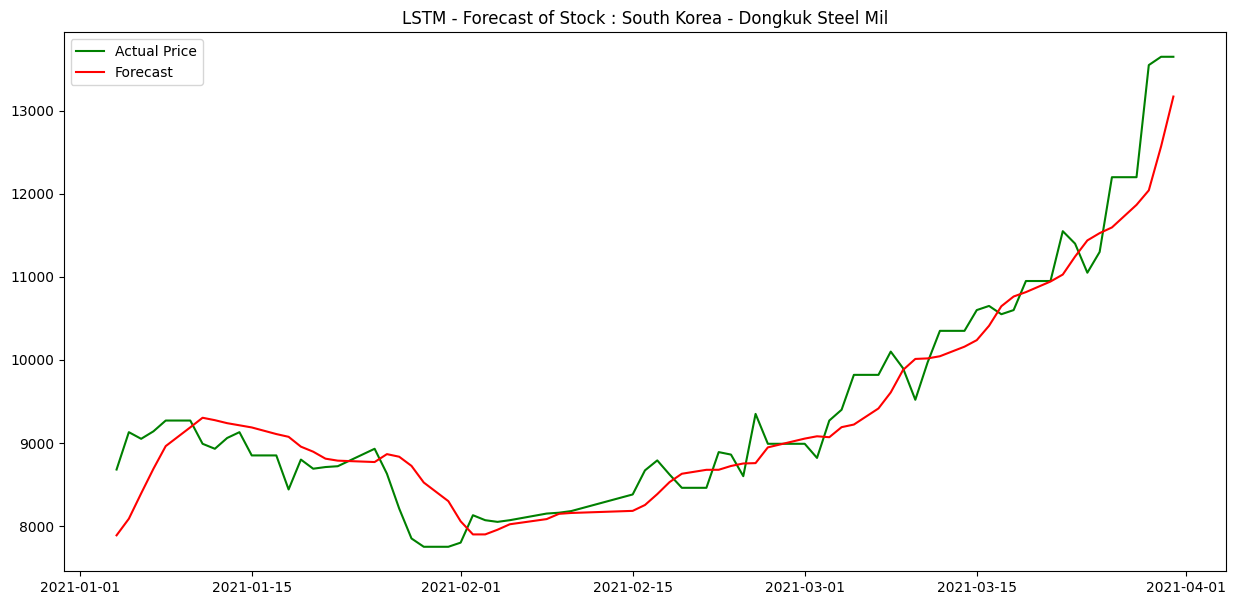

In [22]:
for key in df_dic:
    print(key)
    lstm_model[key], forecast_lstm[key] = lstm(df_dic[key],name=key)

As expected the LSTM model as an ensemble model outperforms the ARIMA model because is more suitable for non-linear patterns and it can captures long-term dependencies and changing path over time which are common aspect of stock prices.